In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.patches import Patch
from scipy.stats import linregress
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scanpy as sc
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import fdrcorrection
import umap
import networkx as nx
#import many
from network import nx_plot 

In [2]:
PALETTE = {"AST": "#8aafa9", 
           'EXC-L23':"#ead1dc",
           'EXC-L4':"#c27ba0",
           'EXC-L5':"#741b47",
            'EXC-L6':"#d9d2e9",
           "EXC-IT":"#c27ba0",
           "EXC-L6-spe":"#d9d2e9",
           "EXC-L6_spe":"#d9d2e9",
                "EXC-L6":"#d9d2e9",
           
           'EXC':"#d9d2e9",
           "INH-CGE":"#f34c0d",
           "INH":"#f34c0d",
           "INH-MGE":"#FCDBCE",
            "MIC":"#165f54",
           # "ENDO-Mural":"#ab910b",
           "Endo":"#ab910b",
           "VLMC":"#fbf0ba",
           "Endo-Mural":"#ab910b",
           "OLD":"#ffc281",
           "OPC":"#7f6140"
          }

palette_exp = {"Tissue":"#2D3047", "Nuclei":"#ffd5c2", "snRNA":"#eef2f3"}

In [3]:
def plot_per_celltype(df_metrics_tot,
                    method,
                    savename,
                    metrics,
                    ):

    start_color = '#FF6B35'
    end_color = '#FFFFFF'

    palette = ["#272300","#443F1C","#746E48","#A9A179","#CDC392","#E8E5DA","#9EB7E5","#648DE5","#304C89"]#, "#08336D"]
    xolorr = "#677CBF"#'#A02c5a'#"#27C196"#"#304C89"
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
    colors = [start_color, end_color]
    cmap = LinearSegmentedColormap.from_list('my_cmap', palette)

    # Convert colormap to seaborn palette
    n_colors = np.linspace(1,0.1,9)  # Number of colors in the palette
    palette = [cmap(it) for it in n_colors]
    fig, axes = plt.subplots(1,len(metrics), figsize=(18,6))
    axes = axes.flatten()
    sns.set(font_scale=2, style="white")
    fontsize=18
    #tmp_method = "RandomForestRegressor"
    tmp_method = method
    df_tmp = df_metrics_tot[df_metrics_tot.method ==tmp_method]
    sns.set(style="white", font_scale=2)
    for indx, it in enumerate(metrics):
        tmp = df_tmp[df_tmp.metrics==it].groupby(["celltype","individualID", "fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,x="celltype",
                hue="celltype",
                y="res", palette=palette,
                ax=ax,
                showmeans=True,
                dodge=False,
                
                   showfliers = True, 
                boxprops={'facecolor':'none', 'edgecolor':xolorr},
                meanprops={"marker":"o",
                    "markerfacecolor":xolorr,
                    "markeredgecolor":xolorr,
                    "markersize":"5"},
                medianprops={'color':xolorr},
    whiskerprops={'color':xolorr},
    capprops={'color':xolorr},
                flierprops={"markerfacecolor":xolorr, "markeredgecolor":xolorr},
                linewidth=0.8)#, notch=True)
        means = tmp.groupby(['celltype'])['res'].median().round(2)
        vertical_offset = tmp['res'].median() * 0.01 # offset from median for display
        print(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        # for xtick in ax.get_xticks():
        #     ax.text(xtick,
        #             means[xtick] + vertical_offset,
        #             means[xtick], 
        #             horizontalalignment='center',
        #             size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        ax.set_title(it)
        ax.set_ylabel("")
       # ax.set_ylim(0,1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend().remove()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savename + "box_comp_CV_CELLTYPE.svg",
                bbox_inches="tight")
   # plt.close("all")
def plot_model_sub(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method", "individualID","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_per_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_genes(df_metrics_tot, metrics,savename, palette=None, thresh=0.3):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method","genes","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
            ax.axhline(y=thresh, c="k", linestyle="--")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
      
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_genes_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_it(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_it_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")

In [4]:
savepath = "/home/eloiseb/data/rna/hu_berson_24_map1/"
if not os.path.exists(savepath):
    os.mkdir(savepath)

celltypes = ["AST", "CA1", "CA2-3", "Cortical", "DG", "Endo-Mural","INH", "MIC", "OLD"]
celltypes = ['AST', 'Endo-Mural', 'EXC-L23', 'EXC-L4', 'EXC-L5', 'EXC-L6',
       'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC']
celltypes = [ 'AST', 'Endo-Mural','EXC-L23', 'EXC-L4', 'EXC-L5', 'EXC-L6',
       'INH', 'MIC', 'OLD', 'OPC']

celltypes = ['AST', 'Endo-Mural', 'EXC', 'INH', 'MIC', 'OLD', 'OPC']

['Cellformer']


/tmp/ipykernel_439332/1175248793.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AST
EXC
Endo-Mural
INH
MIC
OLD
OPC


/tmp/ipykernel_439332/1175248793.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AST
EXC
Endo-Mural
INH
MIC
OLD
OPC


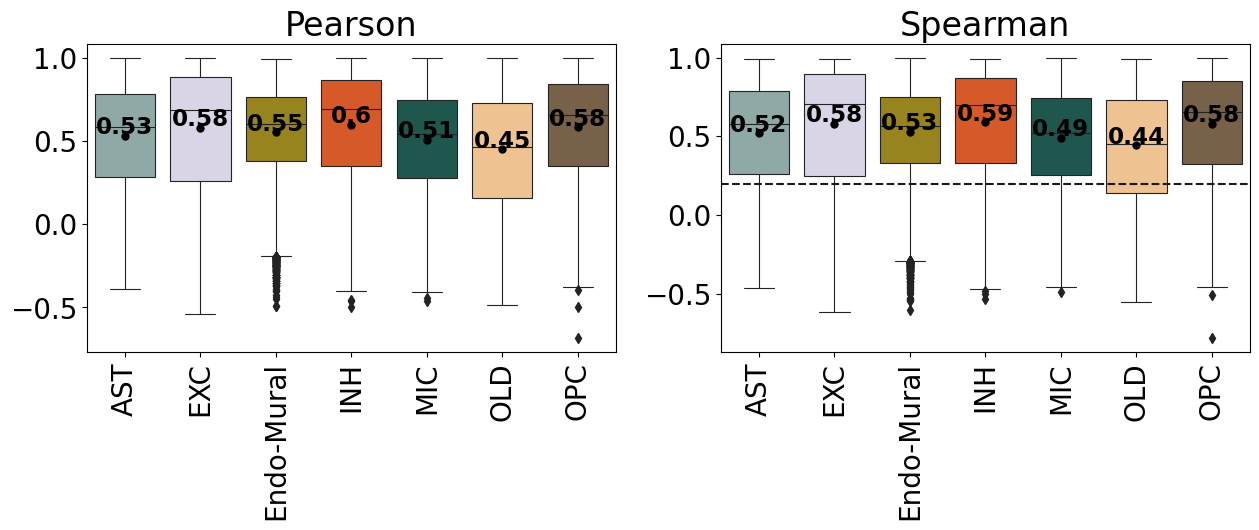

/tmp/ipykernel_439332/1175248793.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
AST
EXC
Endo-Mural
INH
MIC
OLD
OPC


/tmp/ipykernel_439332/1175248793.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AST
EXC
Endo-Mural
INH
MIC
OLD
OPC


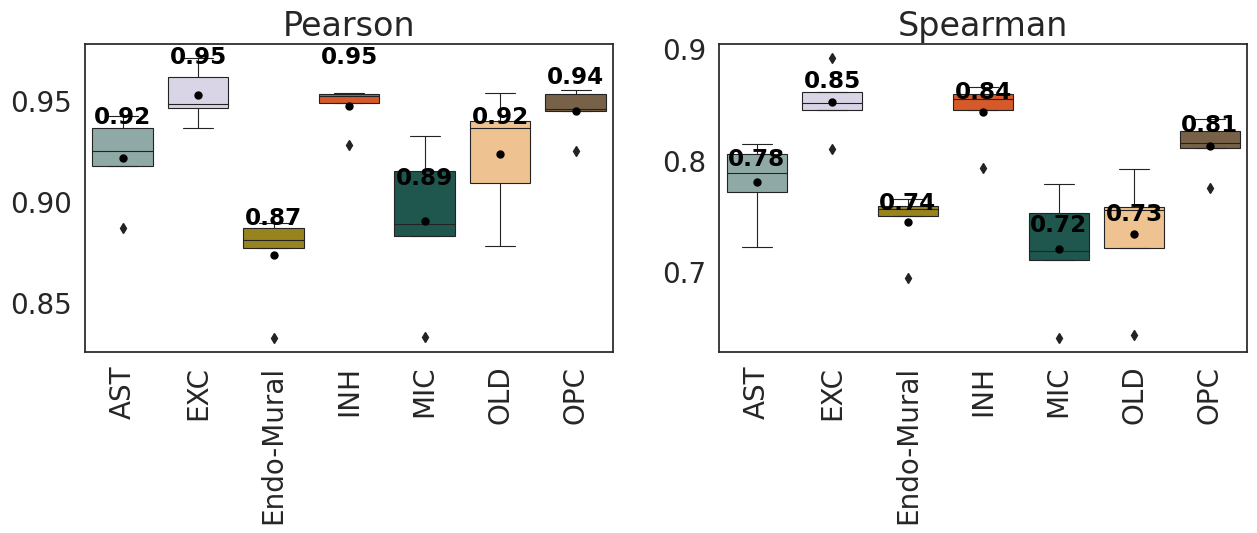

/tmp/ipykernel_439332/1175248793.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_439332/1175248793.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
AST
EXC
Endo-Mural
INH
MIC
OLD
OPC
AST
EXC
Endo-Mural
INH
MIC
OLD
OPC


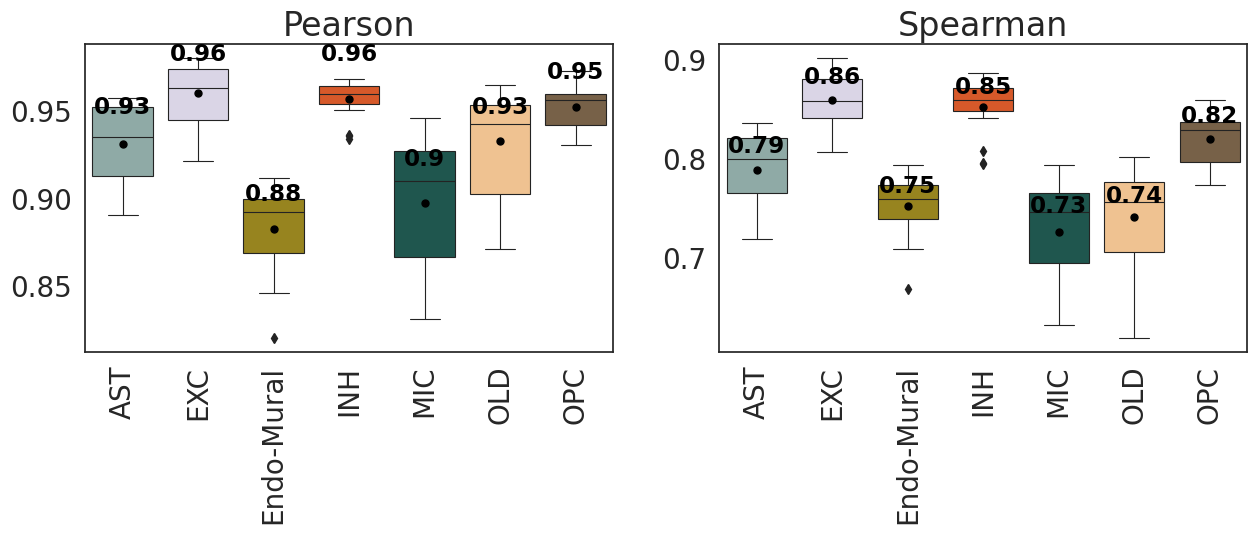

In [5]:
model = "/remote/home/eloiseb/experiments/deconv_rna/berson_map1_18k_totlognorm_nosparse/"
# model = "/remote/test/eloiseb/experiments/deconv_rna/berson_18k_map2_totlognorm_nosparse/"
met = model + "metrics_all_genes.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_genes(df_metrics,metrics, savepath, palette=PALETTE, thresh=0.2)



met = model + "metrics_all_it.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_it(df_metrics,metrics, savepath, palette=PALETTE)

met = model + "metrics_all_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_sub(df_metrics,metrics, savepath, palette=PALETTE)




In [6]:
met = model + "metrics_all_genes.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
tmp = df_metrics[df_metrics.metrics=="spearman"]
tmp["above_0.2"] = tmp.res>0.3
tmp = tmp.groupby([ "celltype", "genes"]).res.mean().reset_index()
tmp["above_0.2"] = tmp.res>0.3
tmp.groupby(["celltype"])["above_0.2"].sum()/tmp.genes.nunique()

/tmp/ipykernel_439332/2691708869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["above_0.2"] = tmp.res>0.3


celltype
AST           0.638872
EXC           0.700958
Endo-Mural    0.644895
INH           0.691596
MIC           0.586696
OLD           0.566329
OPC           0.652231
Name: above_0.2, dtype: float64

In [7]:
tmp

,celltype,genes,res,above_0.2
0,AST,0,0.037743,False
1,AST,1,0.574563,True
2,AST,2,0.265309,False
3,AST,3,0.638147,True
4,AST,4,0.618412,True
...,...,...,...,...
127850,OPC,18260,0.961774,True
127851,OPC,18261,0.924912,True
127852,OPC,18262,0.943437,True
127853,OPC,18263,-0.054941,False


In [8]:
# hvg = pd.read_csv("univer")
# met = model + "metrics_all_genes.csv"
# df_metrics = pd.read_csv(met)
# # df_metrics
# print(hvg)
# df_metrics = df_metrics[df_metrics.genes.isin(hvg.indexes.tolist())]
# df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
# df_metrics["method"] = "Cellformer"
# metrics=[ "pearson", "spearman"]
# plot_model_genes(df_metrics,metrics, savepath + "high_var_gene", palette=PALETTE, thresh=0.3)



In [9]:
df_metrics[df_metrics.metrics =="pearson"].res.mean().mean()

0.5422531651172026

In [10]:
df_metrics[df_metrics.metrics =="spearman"].res.mean().mean()

0.5328091138688832

In [11]:
df_metrics

,Unnamed: 0,celltype,metrics,res,genes,fold,method
0,0.0,AST,spearman,-1.281405e-01,0,fold_0,Cellformer
1,1.0,AST,spearman,5.868937e-01,1,fold_0,Cellformer
2,2.0,AST,spearman,2.070044e-01,2,fold_0,Cellformer
3,3.0,AST,spearman,3.359915e-01,3,fold_0,Cellformer
4,4.0,AST,spearman,5.247742e-01,4,fold_0,Cellformer
...,...,...,...,...,...,...,...
1917820,NaN,OPC,mse,2.886769e-10,18260,fold_4,Cellformer
1917821,NaN,OPC,mse,2.154432e-10,18261,fold_4,Cellformer
1917822,NaN,OPC,mse,2.145735e-10,18262,fold_4,Cellformer
1917823,NaN,OPC,mse,1.271429e-11,18263,fold_4,Cellformer


In [12]:
met = model + "metrics_all_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics[df_metrics.metrics =="spearman"].groupby(["fold"]).res.mean()

fold
fold_0    0.793287
fold_1    0.819583
fold_2    0.802975
fold_3    0.731901
fold_4    0.807569
Name: res, dtype: float64

mse
pearson
spearman


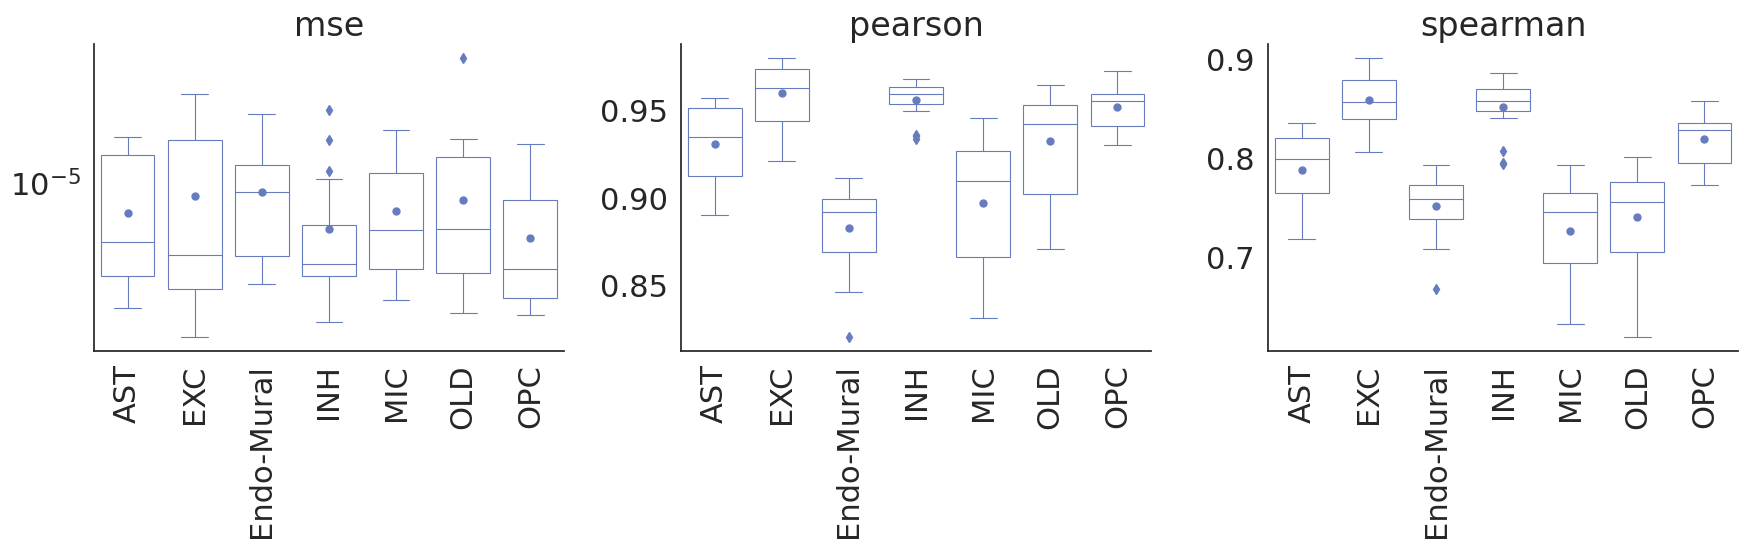

In [13]:

savename = "tmp"
metrics=["mse", "pearson", "spearman"]
df_metrics["method"] = "Cellformer"
plot_per_celltype(df_metrics,
                  "Cellformer",
                     savepath+"results_deconv_Cellformer" ,
                    metrics,
                    )

In [14]:
met = model + "metrics_all_genes.csv"

df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})

print(df_metrics.genes.nunique())
mat = df_metrics[df_metrics.metrics == "spearman"].pivot(index=["celltype", "fold"], columns=["genes"], values="res").fillna(0).reset_index().groupby("celltype")[df_metrics.genes.unique().tolist()].mean()
mat[mat<=0.3] = 0
mask = mat.values
mask[mask>0] = 1
# mask[:,:] = 1
mask.shape
np.count_nonzero(mat,axis=1)

18265


array([11630, 12800, 10733, 12522, 10571, 10344, 11788])

In [15]:
np.savez_compressed(model + "cv_mask.npz", mat=mask)

In [16]:
df_metrics.celltype.unique()


array(['AST', 'Endo-Mural', 'EXC', 'INH', 'MIC', 'OLD', 'OPC'],
      dtype=object)

In [17]:
savename

'tmp'

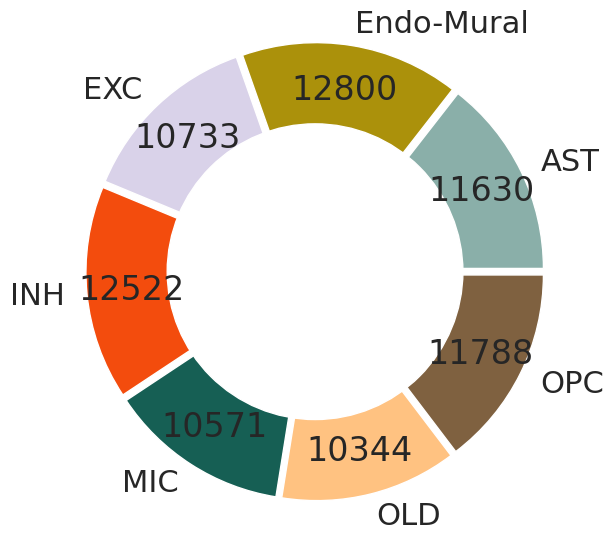

In [18]:
import matplotlib.pyplot as plt
 
# Setting labels for items in Chart

# Setting size in Chart based on 
# given values
values = np.count_nonzero(mat,axis=1)
 
# colors
colors = [PALETTE[it] for it in celltypes]
# explosion
explode = [0.05 for it in celltypes]
total = np.sum(values)
# Pie Chart
plt.pie(values, colors=colors, labels=celltypes,
        # autopct='%1.1f%%',
        autopct=lambda p: '{:.0f}'.format(p*total/100),
        pctdistance=0.8,
        normalize=True,
        radius=1.5,
        explode=explode)
 
# draw circle
centre_circle = plt.Circle((0, 0), 1, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
 
# Adding Title of chart
# plt.title('Employee Salary Details')
plt.savefig(savepath + "pie_predictable_genes.svg",
                bbox_inches="tight")
# Displaying Chart
plt.show()

In [1]:
mixtures = pd.read_csv("/remote/home/eloiseb/data/rna/AD_rna_deconvolution/bulk_nuclei_all_18k.csv")
genes = mixtures.drop(columns="Sample_num").columns.tolist()
genes

NameError: name 'pd' is not defined

In [20]:
model = "/remote/test/eloiseb/experiments/deconv_rna/berson_18k_map2_totlognorm_nosparse_10_all_training/"
model = "/remote/home/eloiseb/experiments/deconv_rna/berson_18k_map2_totlognorm_nosparse_training_all/"
model = "/remote/home/eloiseb/experiments/deconv_rna/berson_map1_18k_totlognorm_nosparse_all_training/"
# model = "/home/eloiseb/home_nalab5/experiments/deconv_rna/berson_map1_18k_totlognorm_nosparse_all_training/"

# Deconvoluted bulk tissue

In [21]:
metadata= pd.read_excel("/home/eloiseb/stanford_drive/data/rna/AD_rna_deconvolution/cases_chosen.xlsx", header=4)
metadata

metadata = metadata.loc[metadata.isna().sum(1)<30]
metadata = metadata.loc[:, metadata.isna().sum(0)<20]
metadata["Sample_num"] = metadata["Name"].astype(int).astype(str) + "_"+metadata["Status"].astype(str)
mapping_ = {int(it):gg for it, gg in zip(metadata["Name"],metadata["Sample_num"])}

In [22]:
# celltypes = ['AST', 'Endo-Mural', 'EXC-L23', 'EXC-L4', 'EXC-L5', 'EXC-L6',
#        'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC']
# # celltypes = ['AST', 'Endo-Mural', 'EXC',
# #        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo', 'EXC-IT',  'EXC-L6-spe',
#        'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC', "VLMC"]
fold = 0
model_f = model + "/exp_kfold_%s/test/"%str(fold)
deconv_ = model_f + "bulk_sample_decon_bulk_tissue_all_18k/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "bulk_sample_decon_bulk_tissue_all_18k/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll[ll<0] = 0
ll.shape
ll = ll*mask[np.newaxis, :, :]

df_tissue = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_tissue.loc[len(df_tissue), :] = [it, ct] + ll[i,j, :].tolist()
# df_tissue = df_tissue[df_tissue.Sample_num.isin(both_exp)]
df_tissue.Sample_num =df_tissue["Sample_num"].astype(int).map(mapping_)
df_tissue["Diagnosis"] = df_tissue["Sample_num"].str.split("_", expand=True)[1].values
df_tissue

,Sample_num,celltypes,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,FAM224B,AC022486.1,HSFY1,HSFY2,TTTY14,KDM5D,TTTY10,EIF1AY,LINC00266-4P,Diagnosis
0,10_ND,AST,0.0,647.879822,0.0,44.75288,1242.762817,167.172714,0.0,0.0,...,0.0,0.0,0.0,0.0,153.810471,959.771179,12.999923,0.0,0.0,ND
1,10_ND,Endo-Mural,0.0,18.626068,7.581229,0.0,38.595131,7.465313,0.0,0.0,...,0.0,0.0,0.0,0.0,39.355713,226.84317,5.388989,0.0,0.0,ND
2,10_ND,EXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.818512,10.000096,0.0,0.0,0.0,ND
3,10_ND,INH,0.0,52.62986,0.0,0.0,435.902466,48.340374,0.0,0.0,...,0.0,0.0,0.0,0.0,47.054733,234.615799,15.212193,0.0,0.0,ND
4,10_ND,MIC,0.0,27.230875,0.0,0.0,81.636253,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,38.223076,246.246811,0.0,0.0,0.0,ND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,9_D,EXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
108,9_D,INH,0.0,81.275452,0.392431,0.0,776.425964,54.516144,0.0,0.0,...,0.0,0.0,0.0,0.0,0.627761,0.017889,0.096335,0.0,0.0,D
109,9_D,MIC,0.0,65.703102,0.0,0.0,155.78244,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.566396,0.0,0.065078,0.0,0.0,D
110,9_D,OLD,0.0,195.494461,18.528368,0.0,496.645905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.397473,0.028665,0.070187,0.020728,0.0,D


/tmp/ipykernel_439332/367745471.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))


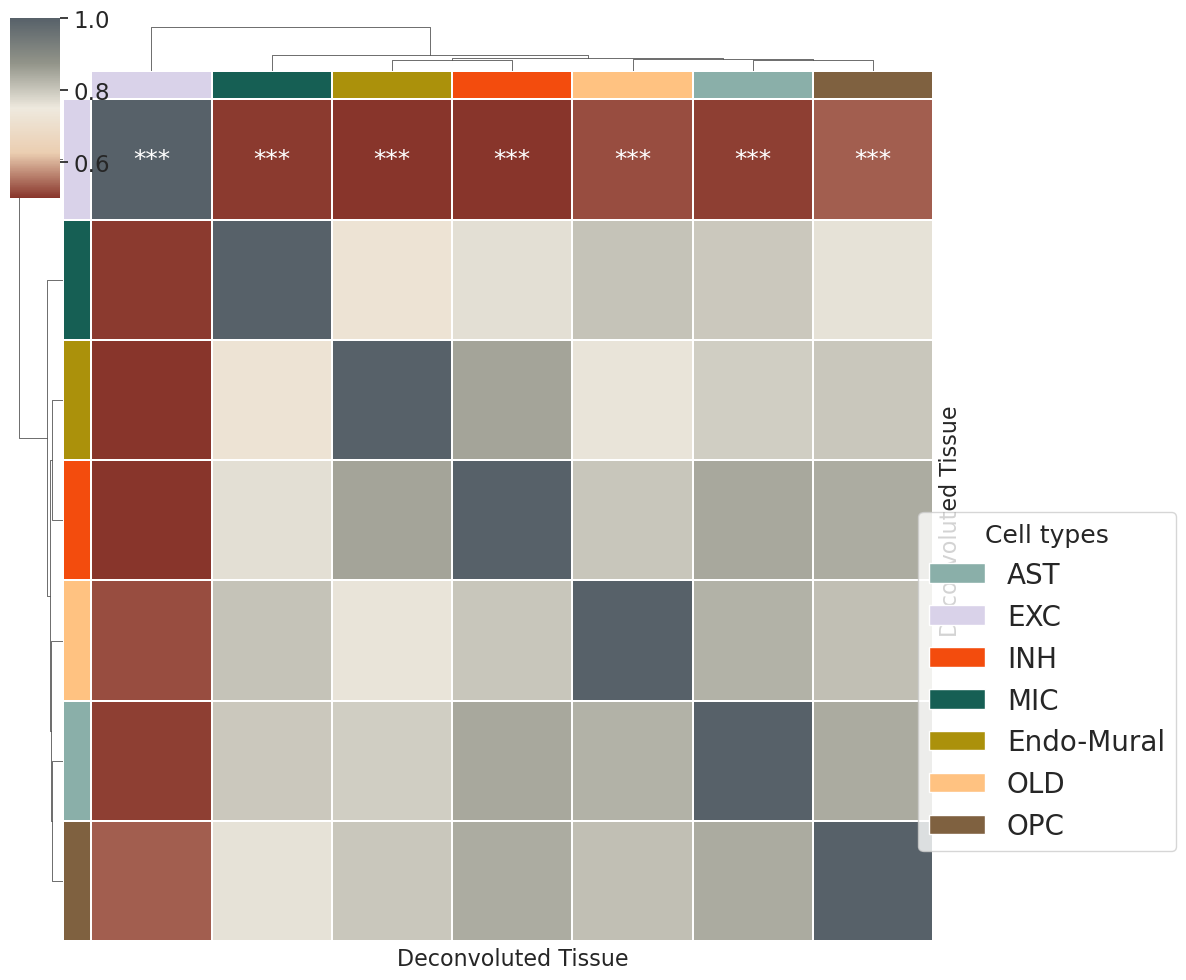

In [26]:
df_tissue.Sample_num.unique()
# df_veh = df_tissue[df_tissue.Sample_num.str.contains("Veh_wt")].sort_values("celltypes")
# mat = df_tissue.sort_values(["celltypes","Diagnosis","Sample_num", ]).set_index(["celltypes","Sample_num" ]).drop(columns="Diagnosis").astype("float").T.corr("spearman")
# mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
# mat.index = ['_'.join(map(str, x)) for x in mat.index]
corr_m =df_tissue.sort_values(["celltypes","Sample_num" ]).groupby(["celltypes"])[genes].mean().astype("float").T
mat = corr_m.corr("spearman")

# mat
pval = corr_m.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*mat.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))
# rho.round(2).astype(str) 
# p = p#.reset_index()

method = "Cellformer"
metrics=["spearman","pearson", "mse"]
end_color = '#A02c5a'
middle_color = '#FFFFFF'
start_color ="#CACACA"# "#27C196"
palette = ["#CDC392","#F1F1E6","#F5F8FF","#9EB7E5","#648DE5","#304C89"]#"#A9A179",
# palette = ["#630012",end_color,middle_color,start_color]


# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
# cmap="Greys"
# sunflow_ =["#f5ab29","#db9925","#8a2f63","#7f2056","#52203d"]
# midnight_ =["#ddd3be","#ededed","#a2a1bb","#6e6d9b","#4b4a71"]

# colors = ["#C8553D","#FFFFFF", "#588B8B"]
colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# pal = PALETTE #{"EXC":"#562c2c", "CA3": "#853140", "CA1":"#FF6E8F", "DG":"#FFBDC8", "INH":"#BFA5A7","ENDO":"#f5dfbb","OLD":"#008A63","OPC":"#27C196", "AST":"#AA4465", "Mural":"#F49A74","MIC":"#6C736A"}

# palette_exp = {"Tissue":"#02B38F", "Nuclei":"#661B00", "snRNA":"#1F3D4C"}
palette_mics = {"ND":"#3A3042", "D":"#DB9D47",}#, "wt3":"#614B0A", "wt4":"#977B3B"}
palette = PALETTE #{"CA1":"#853140","DG":"#FFCAFF", "CA3":"#BC5D81", "Cortical":"#EC90CD", "INH":"#897173", "AST":"#C1FCF6","Oligo":"#00C9BC","Microglia":"#49817B","Endo":"#686B65"}
# col_colors_cell =mat.reset_index()["index"].str.split("_", expand=True)[2].map(palette)
# col_colors_exp =mat.reset_index()["index"].str.split("_", expand=True)[1].map(palette_exp)
row_col_val = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0]
row_col = row_col_val.map(palette)
# row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)
row_colors_exp = []

# ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
# g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=True, xticklabels=True, cmap=cmap, 
#                    row_colors=[col_colors_exp,col_colors_cell], col_colors=[row_colors_exp,row_col], vmin=-1., vmax=1)#,annot=True)
sns.set(font_scale=1.5, style="white")

g = sns.clustermap(mat, annot=p.astype(str), fmt="s",
                   figsize=(10,10), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.5, 
                   row_colors=[row_col],#,row_colors_exp], 
                   col_colors=[row_col],#row_colors_exp],
                   dendrogram_ratio=[0.05, 0.05],
                   linewidth=0.2,
                   col_cluster=True, 
                   row_cluster=True
                  )

palette.update(palette_mics)
to_r = []
for key in palette.keys():
    if key not in row_col_val.unique().tolist() :
        to_r.append(key)

for it in to_r:
    del palette[it]
# handles = [Patch(facecolor=palette[name]) for name in palette if palette[name] in row_colors_exp.unique().tolist() +row_col.unique().tolist() ]
handles = [Patch(facecolor=palette[name]) for name in palette if palette[name] in row_col.unique().tolist() ]

# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap
ax.set_xlabel("Deconvoluted Tissue", fontsize=16)
ax.set_ylabel("Deconvoluted Tissue", fontsize=16)
plt.savefig(os.path.join(savepath, "heatmap_autocorrelation_deconvolution_bulk.svg"))

In [27]:
p

celltypes,AST,EXC,Endo-Mural,INH,MIC,OLD,OPC
celltypes,,,,,,,
AST,***,***,***,***,***,***,***
EXC,***,***,***,***,***,***,***
Endo-Mural,***,***,***,***,***,***,***
INH,***,***,***,***,***,***,***
MIC,***,***,***,***,***,***,***
OLD,***,***,***,***,***,***,***
OPC,***,***,***,***,***,***,***


# Deconvoluted nuclei

In [29]:
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_all_18k/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_all_18k/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll.shape
ll[ll<0] = 0
ll = ll*mask[np.newaxis, :, :]

df_nuclei = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_nuclei.loc[len(df_nuclei), :] = [it, ct] + ll[i,j, :].tolist()

df_nuclei.Sample_num =df_nuclei["Sample_num"].astype(int).map(mapping_)
df_nuclei.Sample_num

0        9_D
1        9_D
2        9_D
3        9_D
4        9_D
       ...  
107    18_ND
108    18_ND
109    18_ND
110    18_ND
111    18_ND
Name: Sample_num, Length: 112, dtype: object

/tmp/ipykernel_439332/271066209.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))


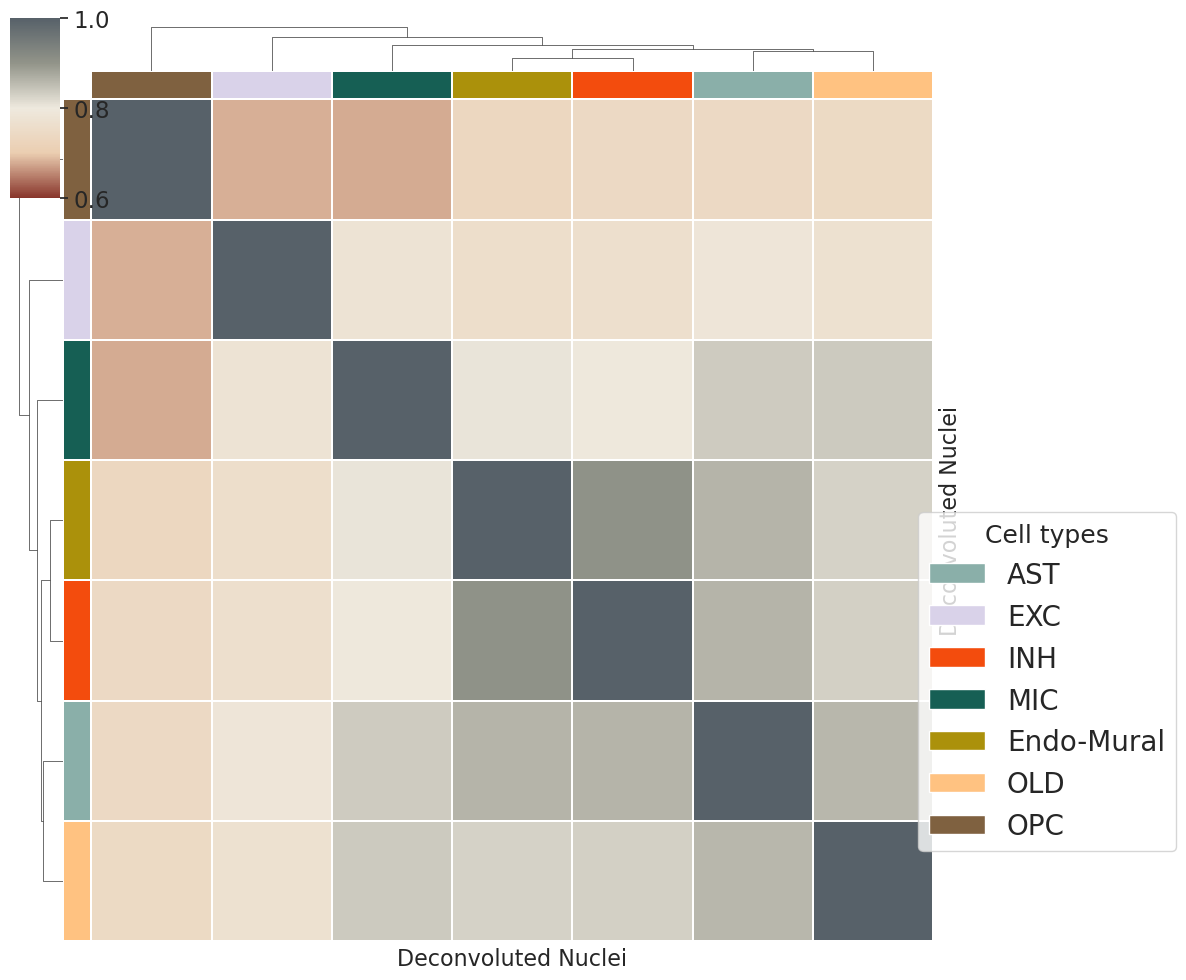

In [30]:
mat = df_nuclei.sort_values(["celltypes","Sample_num" ]).set_index(["celltypes", "Sample_num"]).astype("float").T.corr("spearman")
mat
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]

# mat
corr_m = df_nuclei.sort_values(["celltypes","Sample_num" ]).groupby(["celltypes"])[genes].mean().astype("float").T
mat = corr_m.corr("spearman")
mat

pval = corr_m.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*mat.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))

method = "Cellformer"
metrics=["spearman","pearson", "mse"]
start_color = '#FF6B35'
middle_color = '#FFFFFF'
end_color = "#004E89"
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
# row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)

# ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
# g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=True, xticklabels=True, cmap=cmap, 
#                    row_colors=[col_colors_exp,col_colors_cell], col_colors=[row_colors_exp,row_col], vmin=-1., vmax=1)#,annot=True)


g = sns.clustermap(mat, figsize=(10,10), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.6, 
                   row_colors=[row_col],#,row_colors_exp], 
                   col_colors=[row_col],#row_colors_exp],
                    dendrogram_ratio=[0.05, 0.05],
                   linewidth=0.2,
                   col_cluster=True, 
                   row_cluster=True)

handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap
ax.set_xlabel("Deconvoluted Nuclei", fontsize=16)
ax.set_ylabel("Deconvoluted Nuclei", fontsize=16)
plt.savefig(os.path.join(savepath, "heatmap_autocorrelation_deconvolution_nuclei_vs_bulk.svg"))

In [31]:
p

celltypes,AST,EXC,Endo-Mural,INH,MIC,OLD,OPC
celltypes,,,,,,,
AST,***,***,***,***,***,***,***
EXC,***,***,***,***,***,***,***
Endo-Mural,***,***,***,***,***,***,***
INH,***,***,***,***,***,***,***
MIC,***,***,***,***,***,***,***
OLD,***,***,***,***,***,***,***
OPC,***,***,***,***,***,***,***


In [24]:
# COrrelation matrix

In [32]:
df_tissue["method"] = "Tissue"
df_nuclei["method"] = "Nuclei"

# df_veh = df_veh[df_veh.Sample_num.isin(df_tissue.Sample_num.unique())]
df_concat = pd.concat([df_tissue,df_nuclei])
df_concat 
# mat = df_concat.sort_values("celltypes").set_index(["celltypes","Sample_num",  "method"]).astype("float").T.corr("spearman").reset_index()
# mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes","Sample_num", "method"]).T.reset_index()
#mat = mat[mat.method=="Nuclei"].set_index(["celltypes", "Sample_num", "method"]).sort_values("celltypes")

mat = df_concat.sort_values("celltypes").groupby(["celltypes", "method"])[genes].mean().astype("float").T.corr("spearman").reset_index()
mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes", "method"]).T.reset_index()

mat = mat[mat.method=="Nuclei"].set_index(["celltypes",  "method"]).sort_values("celltypes")

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]

col_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
# col_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)
row_col = pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
# row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)


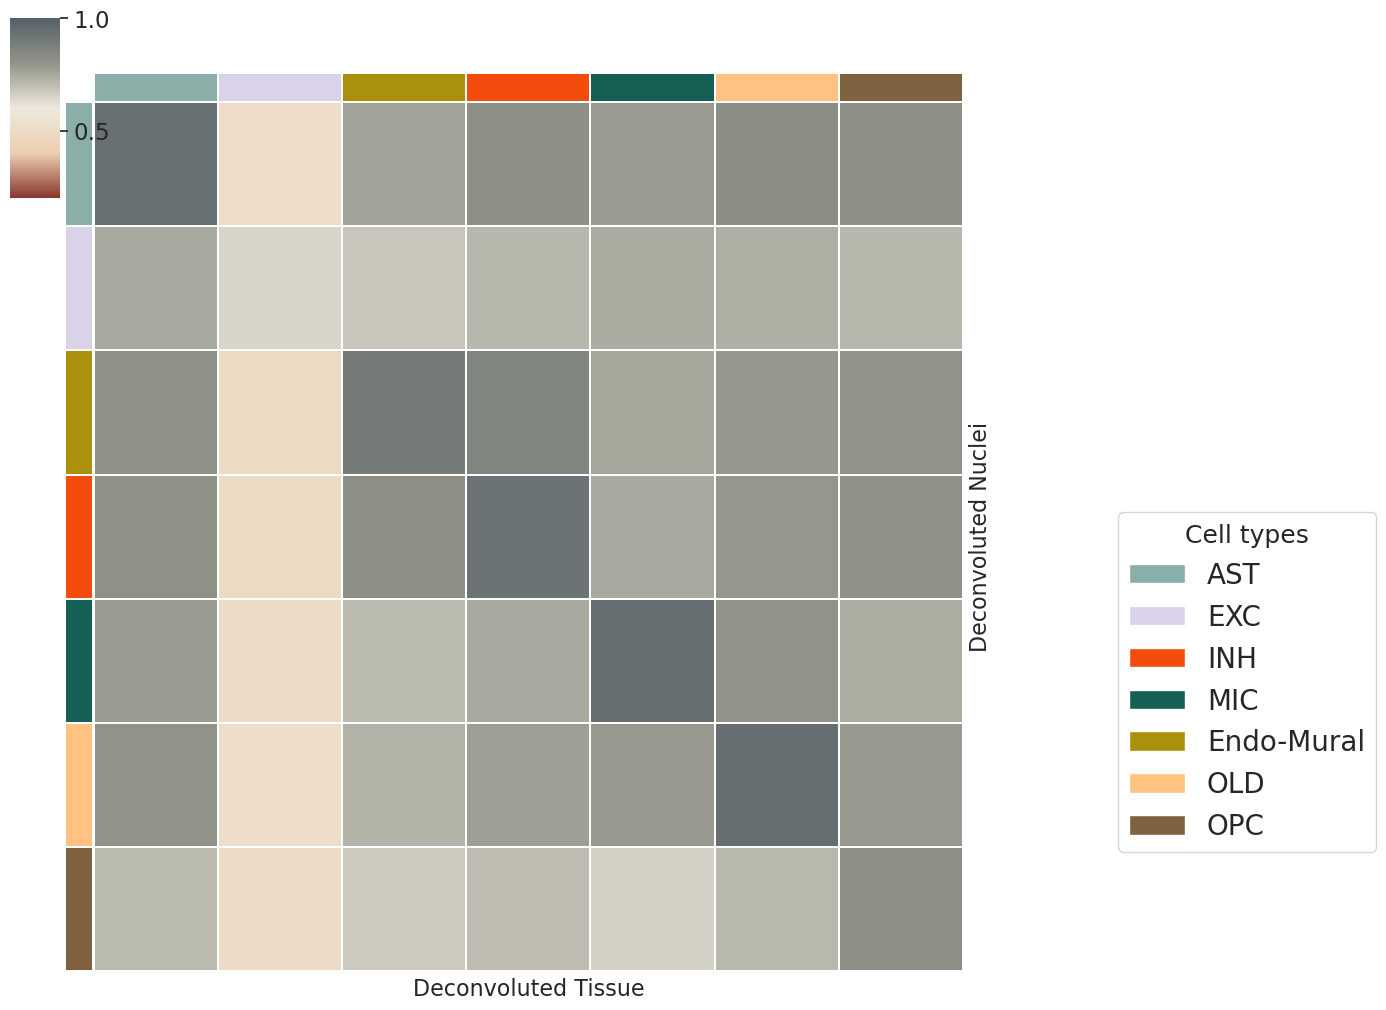

In [33]:

g = sns.clustermap(mat, figsize=(10,10), yticklabels=False, xticklabels=False, cmap=cmap,  
                   vmax=1, vmin=0.2,
                   row_colors=[row_col],#,row_colors_exp],
                   col_colors=[col_col],#col_colors_exp], 
                   dendrogram_ratio=[0.05, 0.05],
                   linewidth=0.2,
                   row_cluster=False, 
                   col_cluster=False)

handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.4, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap


ax = g.ax_heatmap
ax.set_ylabel("Deconvoluted Nuclei",fontsize=16)
ax.set_xlabel("Deconvoluted Tissue",fontsize=16)
plt.savefig(os.path.join(savepath, "heatmap_correlation_deconvolution_bulk_.svg"))

In [285]:
df_concat

,Sample_num,celltypes,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,AC022486.1,HSFY1,HSFY2,TTTY14,KDM5D,TTTY10,EIF1AY,LINC00266-4P,Diagnosis,method
0,10_ND,AST,0.0,647.879822,0.0,44.75288,1242.762817,167.172714,0.0,0.0,...,0.0,0.0,0.0,153.810471,959.771179,12.999923,0.0,0.0,ND,Tissue
1,10_ND,Endo-Mural,0.0,18.626068,7.581229,0.0,38.595131,7.465313,0.0,0.0,...,0.0,0.0,0.0,39.355713,226.84317,5.388989,0.0,0.0,ND,Tissue
2,10_ND,EXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.818512,10.000096,0.0,0.0,0.0,ND,Tissue
3,10_ND,INH,0.0,52.62986,0.0,0.0,435.902466,48.340374,0.0,0.0,...,0.0,0.0,0.0,47.054733,234.615799,15.212193,0.0,0.0,ND,Tissue
4,10_ND,MIC,0.0,27.230875,0.0,0.0,81.636253,0.0,0.0,0.0,...,0.0,0.0,0.0,38.223076,246.246811,0.0,0.0,0.0,ND,Tissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,18_ND,EXC,0.0,33.98251,0.0,0.0,194.060928,58.410622,0.0,0.0,...,0.0,0.0,0.0,276.613098,70.697388,40.31879,0.0,0.0,NaN,Nuclei
108,18_ND,INH,0.0,2.701421,0.0,0.0,3.589573,1.379595,0.0,0.0,...,0.0,0.0,0.0,148.147629,44.177845,18.840691,0.0,0.0,NaN,Nuclei
109,18_ND,MIC,0.0,126.180992,0.0,0.0,737.855652,0.0,0.0,0.0,...,0.0,0.0,0.0,508.807861,449.141541,119.382935,0.0,0.0,NaN,Nuclei
110,18_ND,OLD,0.0,67.949821,0.0,0.0,514.08606,0.0,0.0,0.0,...,0.0,0.0,0.0,392.612488,216.193542,47.831123,50.517147,0.0,NaN,Nuclei


In [ ]:
adata = ad.AnnData(df_concat[genes])
adata.obs["cell type"] =   df_concat["celltypes"].values
adata.obs["Sample_num"] =   df_concat["Sample_num"].values
adata.obs["Diagnosis"] =   adata.obs["Sample_num"].str.split("_", expand=True)[1].values
adata.obs["Diagnosis"] = adata.obs["Diagnosis"].map({"D":"AD","ND":"CTRL"}).values
adata.obs["Method"] =   df_concat["method"].values
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.tsne(adata)
sc.tl.umap(adata)#, init_pos='paga')
sc.pl.umap(adata, color=["cell type"], s=100, palette=PALETTE,save="umap_hu_tissue_ct.svg")
palette_exp["AD"] = "#83869C"
palette_exp["CTRL"] = "#D1D1D1"
palette_exp.update(PALETTE)
sc.pl.umap(adata, color=["cell type","Method", "Diagnosis"],palette=palette_exp,s=100,save="umap_hu_tissue_other.svg")


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [28]:
adata.obs

,cell type,Sample_num,Diagnosis,Method
0,AST,10_ND,CTRL,Tissue
1,Endo-Mural,10_ND,CTRL,Tissue
2,EXC,10_ND,CTRL,Tissue
3,INH,10_ND,CTRL,Tissue
4,MIC,10_ND,CTRL,Tissue
...,...,...,...,...
107,EXC,18_ND,CTRL,Nuclei
108,INH,18_ND,CTRL,Nuclei
109,MIC,18_ND,CTRL,Nuclei
110,OLD,18_ND,CTRL,Nuclei


In [30]:
adata.obs = adata.obs.merge(metadata, on="Sample_num")

In [38]:
adata.obs.rename(columns={"cell type":"celltype", "Method":"Assay"}, inplace=True)

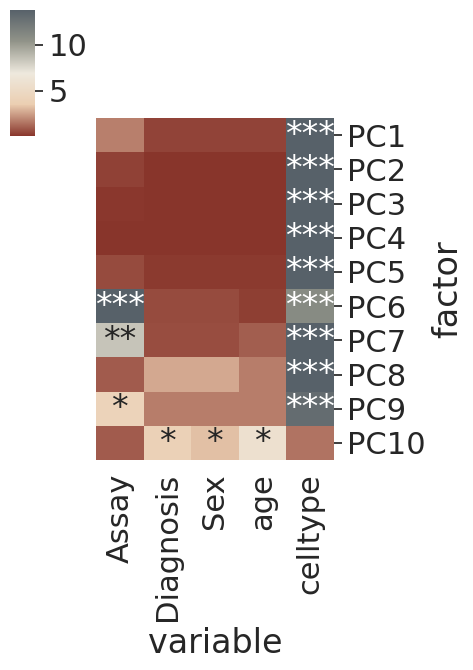

In [132]:
import decoupler as dc

tmp = adata
dc.get_metadata_associations(tmp,
    obs_keys = ['celltype','Sex', "age", "Diagnosis", "Assay"],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)
tmp.uns["pca_anova"]["p_adj"] +=1e-6
tmp.uns["pca_anova"]["-log(q)"] = -np.log(tmp.uns["pca_anova"]["p_adj"])

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def pval_f(x):
    if x<=0.0001:
        return "***"
    elif x<=0.001:
        return "**"
    # elif x<= 0.01:
    #     return "**"
    elif x<=0.05:
        return "*"
    else:
        return ""
toplot = tmp.uns["pca_anova"]
toplot["variable"] = toplot["variable"].replace({"celltypes":"Cell type", "age_death":"Age",
                                                 "tissue":"Region","diagnosis":"Diagnosis",
                                                 "sex":"Sex", "pmi":"PMI"})
toplot= toplot.sort_values(["variable"])
mat = toplot.pivot_table(index="variable", columns="factor", values="-log(q)")
mat = mat.loc[:, ["PC%s"%k for k in range(1,11)]]
mat2 = toplot.pivot_table(index="variable", columns="factor", values="p_adj")
mat2 = mat2.loc[:, ["PC%s"%k for k in range(1,11)]]
annot = mat2.copy()
for it in mat.columns.tolist():
    annot[it] = annot[it].apply(lambda x: pval_f(x)).tolist()
sns.clustermap(mat.T, annot=annot.T, cmap=cmap, fmt="s", row_cluster=False, col_cluster=False,figsize=(,7))
plt.savefig("figures/anova_pca__berson.svg")

/tmp/ipykernel_606783/1610202902.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


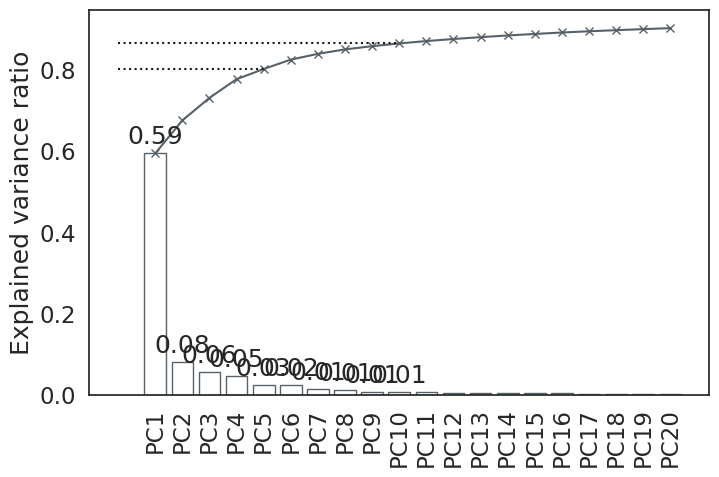

In [88]:
nb = 20
color="#576169"
y = np.cumsum(adata.uns["pca"][ 'variance_ratio'][:nb])
fig, ax= plt.subplots(figsize=(8,5))
ax.plot(["PC%s"%str(k+1) for k in range(nb)],
             y, c=color, marker="x")
bars = ax.bar(["PC%s"%str(k+1) for k in range(nb)], adata.uns["pca"][ 'variance_ratio'][:nb],
       edgecolor=color,
       color="k", fill=False)

for bar in bars[:10]:
   height = bar.get_height()
   ax.annotate(f'{np.round(height,2)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
   textcoords="offset points", ha='center', va='bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
xmin = ax.get_xlim()[0]
ax.hlines(y=y[9],xmin=xmin, xmax=9, linestyle=":", color="k")
ax.hlines(y=y[4],xmin=xmin, xmax=4, linestyle=":", color="k")
ax.set_ylabel("Explained variance ratio")
plt.savefig("figures/anova_pca_variance_berson.svg")

# snRNA

In [35]:
User = "/home/eloiseb/stanford_drive/"
single_cell = ad.read_h5ad("/remote/home/eloiseb/data/rna/AD_rna_deconvolution/adata_gene_matrix_berson_18k_filter.h5ad")

single_cell
single_cell =single_cell[:,single_cell.var.gene_symbol.isin(genes)]



new_genes = single_cell.var.gene_symbol.tolist()

mapping_ct2 = {'Astrocyte':"AST",
               
 'Oligodendrocyte':"OLD",
               
        'Endothelial':"Endo-Mural",
           'VLMC':"Endo-Mural",
           'Microglia-PVM':"MIC",
                'OPC':"OPC",

          
             
               
 'L6 IT':"EXC-L6",
 'L2/3 IT':"EXC-L23",
 'L4 IT':"EXC-L4",
    'L5 IT':"EXC-L5",
        'L5 ET':"EXC-L5",
 'L6 IT Car3':"EXC-L6",
               
    'L6 CT':"EXC-L6",
     'L6b':"EXC-L6",
       'L5/6 NP':"EXC-L6",        

         

'Sncg':"INH-CGE",
 'Vip':"INH-CGE",
 'Lamp5':"INH-CGE",
 'Lamp5 Lhx6':"INH-CGE",
   'Pax6':"INH-CGE",
               
 'Sst':"INH-MGE",              
 'Pvalb':"INH-MGE",      
 'Sst Chodl':"INH-MGE",
 'Chandelier':"INH-MGE",
}




single_cell.obs["celltype"] =single_cell.obs["subclass_name"].replace(mapping_ct2)
single_cell.obs["celltype"] =single_cell.obs["celltype_map3"].replace({"INH-MGE":"INH", "INH-CGE":"INH", "EXC-L2-3":"EXC-L23"})
print(single_cell.obs["celltype"].unique())
single_cell.obs["Sample_num"] = single_cell.obs["Sample_num"].str.upper()
df_nuclei["Sample_num"] = df_nuclei["Sample_num"].str.upper()
df_tissue["Sample_num"] = df_tissue["Sample_num"].str.upper()
single_cell.obs["celltype"] =single_cell.obs["celltype_map1"].replace({'ENDO':'Endo-Mural', 'Mural':'Endo-Mural'})

/tmp/ipykernel_439332/3607197382.py:51: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  single_cell.obs["celltype"] =single_cell.obs["subclass_name"].replace(mapping_ct2)
/tmp/ipykernel_439332/3607197382.py:51: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  single_cell.obs["celltype"] =single_cell.obs["subclass_name"].replace(mapping_ct2)


['AST', 'OLD', 'EXC-L6', 'INH', 'EXC-L5', 'MIC', 'EXC-L4', 'OPC', 'EXC-L23', 'Endo-Mural']
Categories (10, object): ['AST', 'EXC-L23', 'EXC-L4', 'EXC-L5', ..., 'INH', 'MIC', 'OLD', 'OPC']


/tmp/ipykernel_439332/3607197382.py:52: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  single_cell.obs["celltype"] =single_cell.obs["celltype_map3"].replace({"INH-MGE":"INH", "INH-CGE":"INH", "EXC-L2-3":"EXC-L23"})
/tmp/ipykernel_439332/3607197382.py:57: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  single_cell.obs["celltype"] =single_cell.obs["celltype_map1"].replace({'ENDO':'Endo-Mural', 'Mural':'Endo-Mural'})


In [36]:
celltypes
mapping_ct3 = {'Astrocyte':"AST",
               
 'Oligodendrocyte':"OLD",
               
        'Endothelial':"Endo",
           'VLMC':"VLMC",
           'Microglia-PVM':"MIC",
                'OPC':"OPC",

          
             
               
 'L6 IT':"EXC-IT",
 'L2/3 IT':"EXC-IT",
 'L4 IT':"EXC-IT",
    'L5 IT':"EXC-IT",
 'L6 IT Car3':"EXC-IT",    
        'L5 ET':"EXC-IT",

               
    'L6 CT':"EXC-L6_spe",
     'L6b':"EXC-L6_spe",
       'L5/6 NP':"EXC-L6_spe",        

         

'Sncg':"INH-CGE",
 'Vip':"INH-CGE",
 'Lamp5':"INH-CGE",
 'Lamp5 Lhx6':"INH-CGE",
   'Pax6':"INH-CGE",
               
 'Sst':"INH-MGE",              
 'Pvalb':"INH-MGE",      
 'Sst Chodl':"INH-MGE",
 'Chandelier':"INH-MGE",
}
# single_cell.obs["celltype"] =single_cell.obs["subclass_name"].replace(mapping_ct3)

In [37]:
celltypes

['AST', 'Endo-Mural', 'EXC', 'INH', 'MIC', 'OLD', 'OPC']

In [38]:
print(single_cell.obs["celltype"].unique().tolist())
#        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo', 'EXC-IT',  'EXC-L6_spe',
#        'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC', "VLMC"]

['AST', 'OLD', 'EXC', 'INH', 'MIC', 'OPC', 'Endo-Mural']


In [39]:
## for fair comparison removing non predictable genes per celltypes
all_ = []
for ii, it in enumerate(celltypes):
    tmp = single_cell[single_cell.obs.celltype ==it]
    tmp_m = mask[ii,:]
    tmp.X = np.multiply(tmp_m[np.newaxis,:],tmp.X.todense())
    all_.append(tmp)


np.count_nonzero(tmp.X.sum(0))

snRNA = ad.concat(all_)
snRNA.var = single_cell.var


In [40]:
snRNA.obs["Status"] = snRNA.obs["Diagnosis"].apply(lambda x: "D" if x=="AD" else "ND")
snRNA.obs.Sample_num = snRNA.obs["SampleID"].astype(str) + "_"+snRNA.obs["Status"].astype(str)
snRNA.obs.Sample_num.unique()
snRNA.obs.celltype.unique()

['AST', 'Endo-Mural', 'EXC', 'INH', 'MIC', 'OLD', 'OPC']
Categories (7, object): ['AST', 'EXC', 'Endo-Mural', 'INH', 'MIC', 'OLD', 'OPC']

In [41]:
import scanpy as sc
# Perform differential expression analysis
# sc.pp.log1p(adata_sc)
#adata_sc =single_cell
snRNA.var_names =snRNA.var["gene_symbol"]
sc.tl.rank_genes_groups(snRNA, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_sc, min_in_group_fraction=0.25)

FC = 0
Pval=0.05
# Retrieve the results
results = snRNA.uns['rank_genes_groups']
#results
total_gene_de = []
dico_cell_type = {}
for it in snRNA.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(snRNA, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_cell_type[it] = de_genes["names"].tolist()
    total_gene_de += de_genes["names"].tolist()

13916
12683
14404
13761
14191
14302
13473


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New

In [42]:
# sc.pp.normalize_total(single_cell, target_sum=1e4)
sc.pp.log1p(single_cell)

In [43]:
# snRNA = single_cell

In [44]:
# Pseudo bulk from snRNA
gg =snRNA.to_df()
gg.columns = snRNA.var["gene_symbol"].tolist()
gg["Sample_num"] = snRNA.obs["Sample_num"].str.upper()
gg["celltype"] = snRNA.obs["celltype"].values
gg.Sample_num.unique()
gg.shape


pseudo_ = gg.groupby(["Sample_num", "celltype"])[genes].mean()
pseudo_
pseudo_ =  pseudo_.reset_index()

samples = gg.Sample_num.unique().tolist()
mat = np.zeros((gg.Sample_num.nunique(), len(celltypes), len(genes)))
for i,it in enumerate(samples):
    for j,ct in enumerate(celltypes):
        mat[i,j,:] = pseudo_[(pseudo_.Sample_num ==it)&(pseudo_.celltype==ct)][genes].values

# mat = mat*mask[np.newaxis, :, :]
mat

/tmp/ipykernel_439332/105609564.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudo_ = gg.groupby(["Sample_num", "celltype"])[genes].mean()


array([[[0.00000000e+00, 3.67751047e-02, 0.00000000e+00, ...,
         3.32390368e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.82352963e-02, 0.00000000e+00, ...,
         1.47058830e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.25741041e-01, 0.00000000e+00, ...,
         1.40093601e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.20855603e-02, 0.00000000e+00, ...,
         2.67379675e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.72596851e-02, 2.86944048e-03, ...,
         1.52080342e-01, 4.36154939e-02, 0.00000000e+00],
        [0.00000000e+00, 4.40251566e-02, 0.00000000e+00, ...,
         4.21383649e-01, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.85185187e-02, 0.00000000e+00, ...,
         1.11111112e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.44554442e-02, 4.95049497e-03, ...,
         1.83168322e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [45]:
pseudo_new = pd.DataFrame(columns=["Sample_num", "celltype"] +genes)
for i,it in enumerate(samples):
    for j,ct in enumerate(celltypes):

        pseudo_new.loc[len(pseudo_new),:] = [it,ct] + mat[i,j,:].astype(float).tolist()
pseudo_ = pseudo_new

pseudo_ =pseudo_[pseudo_["Sample_num"].isin(df_tissue.Sample_num.unique())]
pseudo_

,Sample_num,celltype,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,NLGN4Y-AS1,FAM224B,AC022486.1,HSFY1,HSFY2,TTTY14,KDM5D,TTTY10,EIF1AY,LINC00266-4P
0,3_D,AST,0.0,0.036775,0.0,0.094767,0.050919,0.019802,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.775106,0.168317,0.33239,0.0,0.0
1,3_D,Endo-Mural,0.0,0.088235,0.0,0.0,0.0,0.029412,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.970588,0.264706,0.147059,0.0,0.0
2,3_D,EXC,0.0,0.525741,0.0,0.0,0.210608,0.051482,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.962559,1.135725,1.400936,0.0,0.0
3,3_D,INH,0.0,0.203704,0.0,0.0,0.074074,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.814815,0.555556,0.888889,0.0,0.0
4,3_D,MIC,0.0,0.032086,0.0,0.0,0.058824,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.705882,0.149733,0.026738,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,20_D,EXC,0.0,0.40158,0.0,0.0,0.203524,0.08627,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.775212,1.288578,1.13062,0.0,0.0
108,20_D,INH,0.0,0.171429,0.025397,0.0,0.133333,0.022222,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.022222,0.774603,0.869841,0.0,0.0
109,20_D,MIC,0.0,0.031175,0.0,0.0,0.021583,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.41247,0.105516,0.052758,0.0,0.0
110,20_D,OLD,0.0,0.022042,0.0058,0.0,0.038283,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.350348,0.182715,0.103248,0.034223,0.0


In [110]:
# Marker genes comparison

In [48]:
# Marker gene deconvoluted
FC=0
df_tissue
df_nn = df_nuclei[df_nuclei.Sample_num.isin(snRNA.obs.Sample_num)]
df_tt = df_tissue[df_tissue.Sample_num.isin(snRNA.obs.Sample_num)]

adata_tissue = ad.AnnData(df_tt[new_genes].astype(float))
adata_tissue.obs["celltype"] = df_tt["celltypes"].astype("category").values
adata_tissue.obs["Sample_num"] = df_tt["Sample_num"].values
adata_nuclei = ad.AnnData(df_nn[new_genes].astype(float))
adata_nuclei.obs["celltype"] = df_nn["celltypes"].astype("category").values
adata_nuclei.obs["Sample_num"] = df_nn["Sample_num"].values
adata_nuclei

adata_pseudo = ad.AnnData(pseudo_[new_genes].astype(float))
adata_pseudo.obs["celltype"] = pseudo_["celltype"].astype("category").values
adata_pseudo.obs["Sample_num"] = pseudo_["Sample_num"].values
adata_pseudo


# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_tissue, groupby='celltype')#,method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_tissue.uns['rank_genes_groups']
#results
dico_tissue = {}
for it in adata_tissue.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_tissue, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_tissue[it] = de_genes["names"].tolist()
    
import scanpy as sc
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_nuclei, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_nuclei.uns['rank_genes_groups']
#results
dico_nuclei = {}
for it in adata_nuclei.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_nuclei, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_nuclei[it] = de_genes["names"].tolist()


sc.tl.rank_genes_groups(adata_pseudo, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_pseudo.uns['rank_genes_groups']
#results
dico_pseudo = {}
for it in adata_pseudo.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_pseudo, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_pseudo[it] = de_genes["names"].tolist()

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero

13437
11733
14065
10460
6587
7504
13097


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1


12977
6405
13262
5767
11401
7018
14001


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1


11944
11313
13701
12165
13261
13219
8602


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New

In [112]:
dico_pseudo.keys()

dict_keys(['AST', 'Endo-Mural', 'EXC', 'INH', 'MIC', 'OLD', 'OPC'])

In [113]:
import pickle
fi = open("./dico_marker_deconv_tissue","wb")
pickle.dump(dico_tissue, fi) 
fi = open("./dico_marker_deconv_nuclei","wb")
pickle.dump(dico_nuclei, fi) 
fi = open("./dico_marker_deconv_sn","wb")
pickle.dump(dico_cell_type, fi) 

AST
Endo-Mural
EXC
INH
MIC
OLD
OPC
None


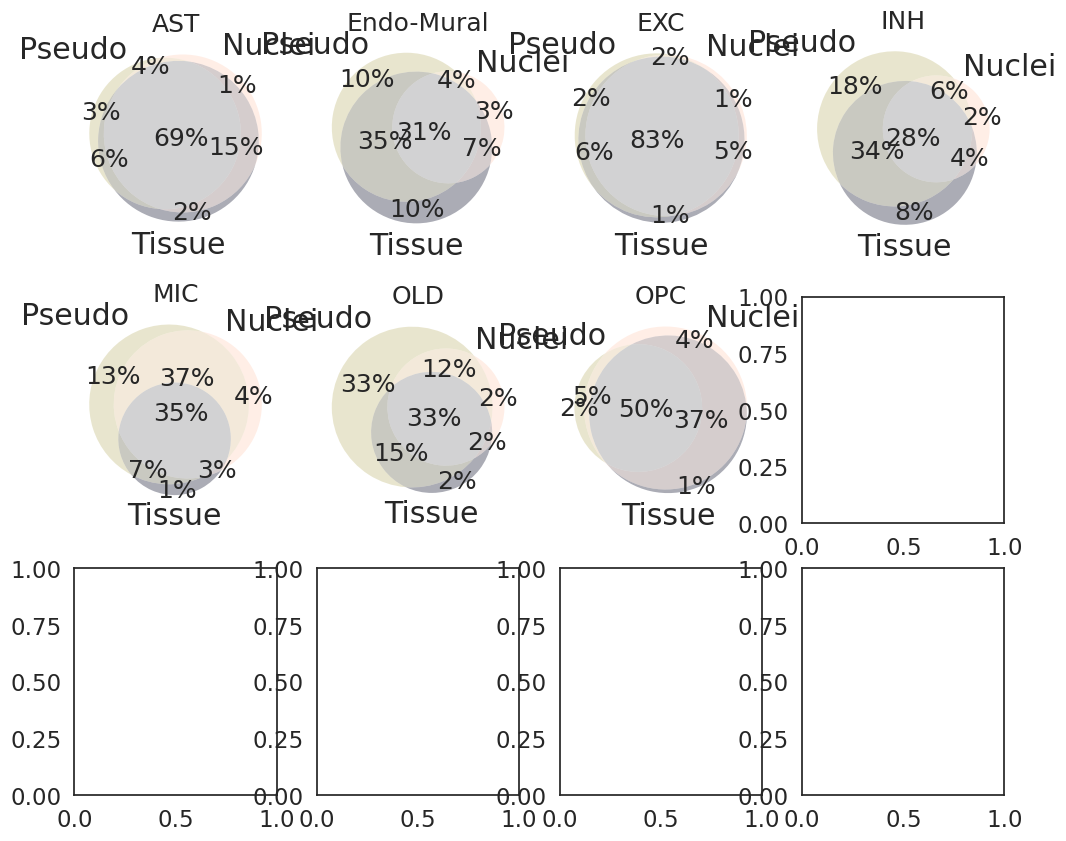

,Cell type,Overlap Type,Number of genes
0,AST,snRNA-deconvoluted nuclei,0.81814
1,AST,snRNA-deconvoluted tissue,0.820198
2,AST,Deconvoluted tissue unique,0.179802
3,AST,Deconvoluted nuclei unique,0.18186
4,Endo-Mural,snRNA-deconvoluted nuclei,0.779703
5,Endo-Mural,snRNA-deconvoluted tissue,0.795364
6,Endo-Mural,Deconvoluted tissue unique,0.204636
7,Endo-Mural,Deconvoluted nuclei unique,0.220297
8,EXC,snRNA-deconvoluted nuclei,0.940884
9,EXC,snRNA-deconvoluted tissue,0.937576


In [117]:
## overlap
#palette_exp = {"Tissue":"#2D3047", "Nuclei":"#ffd5c2", "snRNA":"#eef2f3"}
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])


from matplotlib_venn import venn3
de_over = pd.DataFrame(columns=["Cell type", "Overlap Type", "Number of genes"])
fig, axes =plt.subplots(3,4, figsize=(12,10))
axes =axes.flatten()
for ii, it in enumerate(celltypes):
    print(it)
    ax =axes[ii]
    total = len(list(set(dico_pseudo[it])))
    total += len(list(set(dico_tissue[it])))
    total+= len(list(set(dico_nuclei[it])))
    tissue_u = [itt for itt in list(set(dico_tissue[it])) if itt not in list(set(dico_pseudo[it]))]# if itt not in list(set(dico_nuclei[it]))]
    tissue_n = [itt for itt in list(set(dico_nuclei[it])) if itt not in list(set(dico_pseudo[it]))]# if itt not in list(set(dico_tissue[it]))]
    overlap_3 = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_pseudo[it])) if itt in list(set(dico_tissue[it]))]

    overlap_tissue = [itt for itt in list(set(dico_tissue[it])) if itt in list(set(dico_pseudo[it]))]# if itt not in overlap_3]
    overlap_nuclei = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_pseudo[it]))]# if itt not in overlap_3]
    total = len(set(dico_pseudo[it]).union(set(dico_nuclei[it])).union(set(dico_tissue[it])))
    v = venn3([set(dico_pseudo[it]), set(dico_nuclei[it]), set(dico_tissue[it])],
          ["Pseudo", "Nuclei","Tissue"], ax=ax,subset_label_formatter=lambda x: f"{(x/total):1.0%}")
    
    v.get_patch_by_id('100').set_color("#C7C085")
    v.get_patch_by_id('100').set_edgecolor('none')
    v.get_patch_by_id('010').set_color(palette_exp["Nuclei"])
    v.get_patch_by_id('010').set_edgecolor('none')
    v.get_patch_by_id('001').set_color(palette_exp["Tissue"])
    v.get_patch_by_id('001').set_edgecolor('none')
    
    v110 = combine_hex_values({"C7C085": 0.5, "ffd5c2": 0.5})
    # print(v110)
    v.get_patch_by_id('110').set_color("#%s"%v110)
    v.get_patch_by_id('110').set_edgecolor('none')
    try:
        v101 = combine_hex_values({"C7C085": 0.5, "2D3047": 0.5})
        v.get_patch_by_id('101').set_color("#%s"%v101)
        v.get_patch_by_id('101').set_edgecolor('none')
    except:
        print("None")
    try:
        
        v011 = combine_hex_values({"ffd5c2": 0.5, "2D3047": 0.5})
        v.get_patch_by_id('011').set_color("#%s"%v011)
        v.get_patch_by_id('011').set_edgecolor('none')
        # plt.title("Number of OCR DE in %s (%s)"%(ct,br))
    except:
        print("None")
    # de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue/nuclei", len(overlap_3)]
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted nuclei", len(overlap_nuclei)/len(list(set(dico_nuclei[it])))] 
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue", len(overlap_tissue)/len(list(set(dico_tissue[it])))]
    de_over.loc[len(de_over),:] = [it, "Deconvoluted tissue unique", len(tissue_u)/len(list(set(dico_tissue[it])))]
    de_over.loc[len(de_over),:] = [it, "Deconvoluted nuclei unique", len(tissue_n)/len(list(set(dico_nuclei[it])))]
    ax.set_title(it)
plt.savefig(savepath +"venn_overlap_pseudo.svg")
plt.show()
de_over

In [ ]:
# ## overlap
# from matplotlib_venn import venn3
# de_over = pd.DataFrame(columns=["Cell type", "Overlap Type", "Number of genes"])
# fig, axes =plt.subplots(6,2, figsize=(8,18))
# axes =axes.flatten()
# for ii, it in enumerate(celltypes):
#     print(it)
#     ax =axes[ii]
#     total = len(list(set(dico_cell_type[it])))
#     total += len(list(set(dico_tissue[it])))
#     total+= len(list(set(dico_nuclei[it])))
#     overlap_tissue = [itt for itt in list(set(dico_tissue[it])) if itt in list(set(dico_cell_type[it]))]
#     overlap_nuclei = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_cell_type[it]))]
#     overlap_3 = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_cell_type[it])) if itt in list(set(dico_tissue[it]))]

#     venn3([set(dico_cell_type[it]), set(dico_nuclei[it]), set(dico_tissue[it])], ["snRNA", "Nuclei","Tissue"], ax=ax)#,subset_label_formatter=lambda x: f"{(x/total):1.0%}")
   
#     de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue/nuclei", len(overlap_3)]
#     de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted nuclei", len(overlap_nuclei)-len(overlap_3)] 
#     de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue", len(overlap_tissue)-len(overlap_3)]
#     ax.set_title(it)
# plt.savefig(savepath +"venn_overlap.svg")
# plt.show()
# de_over

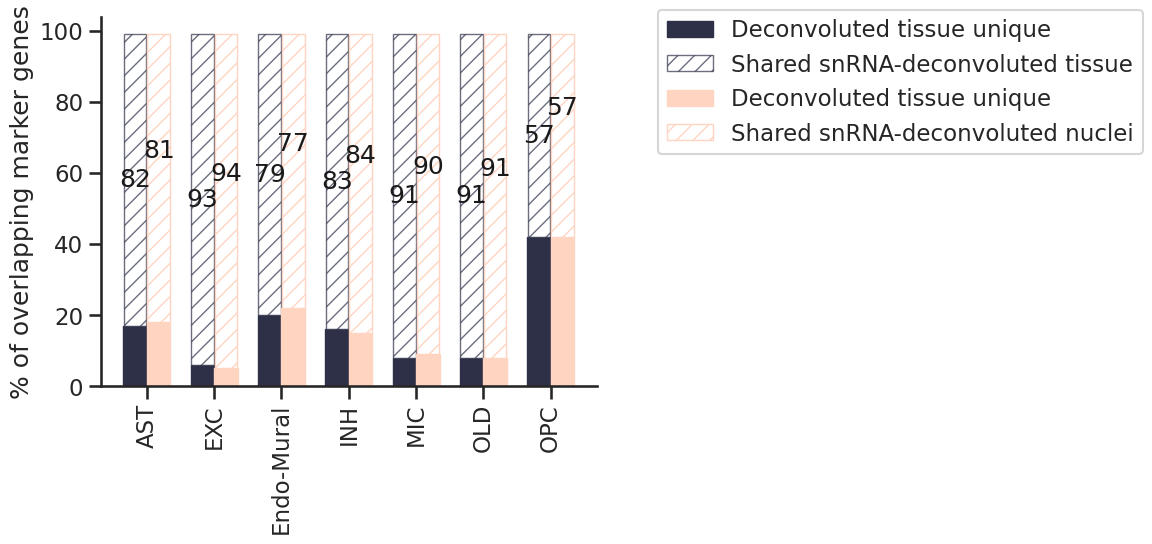

In [249]:
tmp = de_over[de_over["Overlap Type"].str.contains("tissue")].set_index(["Cell type","Overlap Type"]).unstack(["Overlap Type"])
tmp.columns = [it[1] for it in tmp.columns.tolist()]

deconv_tissue_u = (np.round(tmp["Deconvoluted tissue unique"]*100)).astype(int).tolist()
snrna_t = (np.round(tmp["snRNA-deconvoluted tissue"]*100)).astype(int).tolist()

tmp = de_over[de_over["Overlap Type"].str.contains("nuclei")].set_index(["Cell type","Overlap Type"]).unstack(["Overlap Type"])
tmp.columns = [it[1] for it in tmp.columns.tolist()]

deconv_nuclei_u = (np.round(tmp["Deconvoluted nuclei unique"]*100)).astype(int).tolist()
snrna_n = (np.round(tmp["snRNA-deconvoluted nuclei"]*100)).astype(int).tolist()

tick = tmp.index.tolist()
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 0.35
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(deconv_tissue_u))
    neg_bar_positions = pos_bar_positions + bar_width
    
    # make bar plots
    dec_t_bar = plt.bar(pos_bar_positions, deconv_tissue_u, bar_width,
                              color=palette_exp["Tissue"],
                                edgecolor=palette_exp["Tissue"],
                        linewidth=line_width,
                              label='Deconvoluted tissue unique')
    
    snrna_t_bar = plt.bar(pos_bar_positions, snrna_t, bar_width-epsilon,
                              bottom=deconv_tissue_u,
                              alpha=opacity,
                              color='white',
                              edgecolor=palette_exp["Tissue"],
                              linewidth=line_width,
                              hatch='//',
                              label='Shared snRNA-deconvoluted tissue')
    plt.bar_label(snrna_t_bar, label_type='center', color="k")
    dec_n_bar = plt.bar(neg_bar_positions, deconv_nuclei_u, bar_width,
                              color=palette_exp["Nuclei"],
                          edgecolor=palette_exp["Nuclei"],
                        linewidth=line_width,
                              label='Deconvoluted tissue unique')
    snrna_n_bar = plt.bar(neg_bar_positions, snrna_n, bar_width-epsilon,
                              bottom=deconv_nuclei_u,
                              color="white",
                              hatch='//',
                              edgecolor=palette_exp["Nuclei"],
                              # ecolor="#0000DD",
                              linewidth=line_width,
                              label='Shared snRNA-deconvoluted nuclei')
    plt.bar_label(snrna_n_bar, label_type='center', color="k", padding=20)

    plt.xticks((neg_bar_positions+pos_bar_positions)/2, tick, rotation=90)

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    sns.despine()
    plt.ylabel("% of overlapping marker genes")
    plt.savefig(os.path.join(savepath, "overlap_marker_gene_barplot_BOTH.svg"))
    plt.show()

# Correlation deconv snRNA

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_439332/3442212120.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))


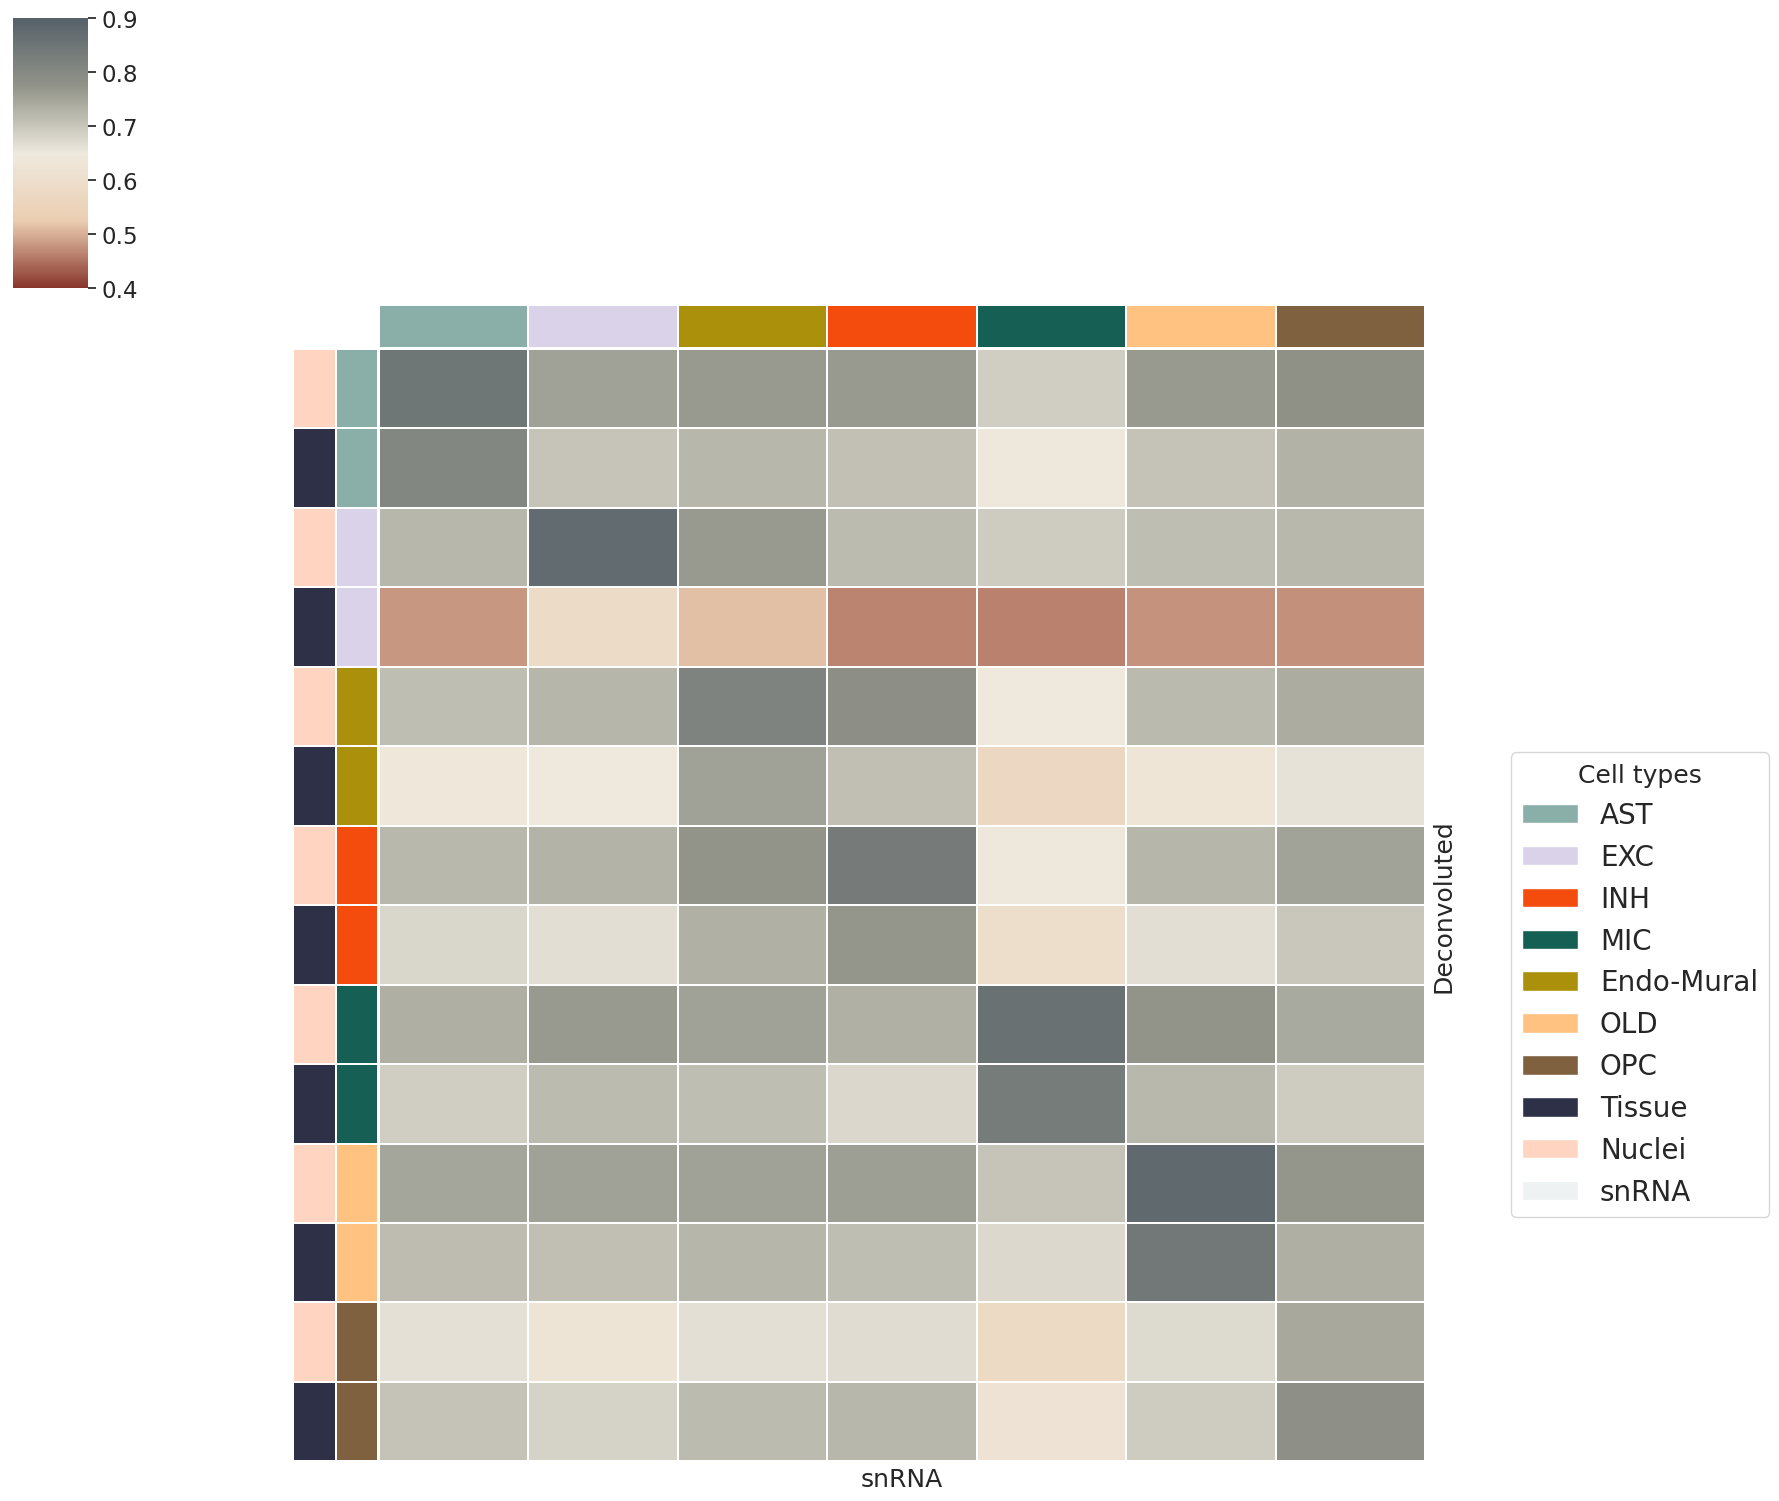

In [50]:
#sc_rna = single_cell[single_cell.obs.Sample_num.isin(df_nn.Sample_num)]

adata_sc = ad.AnnData(pseudo_[genes].astype(float))
adata_sc.obs["celltype"] = pseudo_["celltype"].astype(str).values
adata_sc.obs["Sample_num"] = pseudo_["Sample_num"].astype(str).values
adata_sc
df_scrna = adata_sc.to_df()
all_genes=genes#sc_rna.var["gene_symbol"].values.tolist()
df_scrna.columns = all_genes
df_scrna["Sample_num"] = adata_sc.obs["Sample_num"].values
df_scrna["celltype"] = adata_sc.obs["celltype"].values

df_log_tis = adata_tissue.to_df()
df_log_tis.columns = all_genes
df_log_tis["Sample_num"] = adata_tissue.obs["Sample_num"].values
df_log_tis["celltype"] = adata_tissue.obs["celltype"].values

df_log_nuc = adata_nuclei.to_df()
df_log_nuc.columns = all_genes
df_log_nuc["Sample_num"] = adata_nuclei.obs["Sample_num"].values
df_log_nuc["celltype"] = adata_nuclei.obs["celltype"].values


df_log_nuc["method"]= "Nuclei"
df_log_tis["method"] ="Tissue"
df_scrna["method"] = "snRNA"
df_scrna = df_scrna.groupby(["celltype", "method", "Sample_num"])[all_genes].sum().reset_index()

combined = pd.concat([df_log_nuc, df_log_tis, df_scrna])

combined

mE= combined.groupby(["celltype", "method"])[all_genes].mean().reset_index()
mE


corr_m = mE.set_index(["celltype", "method"])[all_genes].astype(float).T
mat = corr_m.corr("spearman")#.reset_index()
mat

pval = corr_m.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*mat.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.5] if x<=t]))

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat =mat.reset_index()

p.columns = ['_'.join(map(str, x)) for x in p.columns]
p =p.reset_index()

x = "snRNA"
mat = mat[mat["method"] ==x].set_index(["celltype", "method"]).T.reset_index()
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]

p = p[p["method"] ==x].set_index(["celltype", "method"]).T.reset_index()
p.columns = ['_'.join(map(str, x)) for x in p.columns]


y="Nuclei"
y2="Tissue"
mat = mat[(mat["index_"].str.contains(y)) | (mat["index_"].str.contains(y2)) ].set_index(["index_"])
#mat = mat[(mat["index_"].str.contains(y)) ].set_index(["index_"])
p = p[(p["index_"].str.contains(y)) | (p["index_"].str.contains(y2)) ].set_index(["index_"])


# print(mat)
# sns.set(font_scale=2)
#fig, ax = plt.subplot

# palette = {"CA1":"#210124","DG":"#C24F7D", "CA3":"#4B072E", "Cortical":"#750D37", "INH":"#94767C", "AST":"#B3DEC1","Oligo":"#74E399","Microglia":"#A4AA9F","Endo":"#686B65"}
pal = {"EXC":"#562c2c", "CA3": "#853140", "CA1":"#FF6E8F", "DG":"#FFBDC8", "INH":"#BFA5A7","ENDO":"#f5dfbb","OLD":"#008A63","OPC":"#27C196", "AST":"#AA4465", "Mural":"#F49A74","MIC":"#6C736A"}
palette = PALETTE
col_colors_cell =mat.reset_index()["index_"].str.split("_", expand=True)[0].map(PALETTE)
col_colors_exp =mat.reset_index()["index_"].str.split("_", expand=True)[1].map(palette_exp)

row_col_val = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0]
row_col = row_col_val.map(PALETTE)
row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_exp)

ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap, 
                   row_colors=[row_colors_exp,col_colors_cell], col_colors=[row_col], linewidth=0.2, vmin=0.4,vmax=0.9
                  )#,annot=True)
ax = g.ax_heatmap
ax.set_xlabel("snRNA")
ax.set_ylabel("Deconvoluted")
# plt.legend()

to_r = []
for key in palette.keys():
    if key not in row_col_val.unique().tolist() :
        to_r.append(key)

for it in to_r:
    del palette[it]


handles = [Patch(facecolor=palette[name]) for name in palette]
handles += [Patch(facecolor=palette_exp[name]) for name in palette_exp]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
palette.update(palette_exp)
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig(os.path.join(savepath, "heat_matrix_corr_snrna_deconvoluted_hu.svg"))



In [51]:
p

,AST_snRNA,EXC_snRNA,Endo-Mural_snRNA,INH_snRNA,MIC_snRNA,OLD_snRNA,OPC_snRNA
index_,,,,,,,
AST_Nuclei,***,***,***,***,***,***,***
AST_Tissue,***,***,***,***,***,***,***
EXC_Nuclei,***,***,***,***,***,***,***
EXC_Tissue,***,***,***,***,***,***,***
Endo-Mural_Nuclei,***,***,***,***,***,***,***
Endo-Mural_Tissue,***,***,***,***,***,***,***
INH_Nuclei,***,***,***,***,***,***,***
INH_Tissue,***,***,***,***,***,***,***
MIC_Nuclei,***,***,***,***,***,***,***


In [120]:
corr_ = mat.reset_index().melt(id_vars=["index_"])
corr_.columns = ["a", "b", "value"]
corr_ =corr_[corr_["a"] != corr_["b"]]

corr_["a_type"] = corr_["a"].str.split("_", expand=True)[1]
corr_["b_type"] = corr_["b"].str.split("_", expand=True)[1]
corr_["a_celltype"] = corr_["a"].str.split("_", expand=True)[0]
corr_["b_celltype"] = corr_["b"].str.split("_", expand=True)[0]
corr_["type"] = (corr_["a_celltype"] == corr_["b_celltype"]).apply(lambda x: "same" if x==1 else "different")
corr_
# m = pd.DataFrame(np.sort(corr_[['a','b']], axis=1), index=corr_.index).duplicated()
# m.sum()

# tmp = corr_[~m]
# tmp

# corr_[['a','b']].values

# np.sort(corr_[['a','b']], axis=1)

,a,b,value,a_type,b_type,a_celltype,b_celltype,type
0,AST_Nuclei,AST_snRNA,0.847488,Nuclei,snRNA,AST,AST,same
1,AST_Tissue,AST_snRNA,0.807571,Tissue,snRNA,AST,AST,same
2,EXC_Nuclei,AST_snRNA,0.723316,Nuclei,snRNA,EXC,AST,different
3,EXC_Tissue,AST_snRNA,0.481116,Tissue,snRNA,EXC,AST,different
4,Endo-Mural_Nuclei,AST_snRNA,0.713040,Nuclei,snRNA,Endo-Mural,AST,different
...,...,...,...,...,...,...,...,...
93,MIC_Tissue,OPC_snRNA,0.693502,Tissue,snRNA,MIC,OPC,different
94,OLD_Nuclei,OPC_snRNA,0.772528,Nuclei,snRNA,OLD,OPC,different
95,OLD_Tissue,OPC_snRNA,0.734739,Tissue,snRNA,OLD,OPC,different
96,OPC_Nuclei,OPC_snRNA,0.744404,Nuclei,snRNA,OPC,OPC,same


In [251]:
corr_["type"] = corr_["type"].map({"same":"Same cell type", 

,a,b,value,a_type,b_type,a_celltype,b_celltype,type
0,AST_Nuclei,AST_snRNA,0.847488,Nuclei,snRNA,AST,AST,same
1,AST_Tissue,AST_snRNA,0.807571,Tissue,snRNA,AST,AST,same
2,EXC_Nuclei,AST_snRNA,0.723316,Nuclei,snRNA,EXC,AST,different
3,EXC_Tissue,AST_snRNA,0.481116,Tissue,snRNA,EXC,AST,different
4,Endo-Mural_Nuclei,AST_snRNA,0.713040,Nuclei,snRNA,Endo-Mural,AST,different
...,...,...,...,...,...,...,...,...
93,MIC_Tissue,OPC_snRNA,0.693502,Tissue,snRNA,MIC,OPC,different
94,OLD_Nuclei,OPC_snRNA,0.772528,Nuclei,snRNA,OLD,OPC,different
95,OLD_Tissue,OPC_snRNA,0.734739,Tissue,snRNA,OLD,OPC,different
96,OPC_Nuclei,OPC_snRNA,0.744404,Nuclei,snRNA,OPC,OPC,same


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

same_Nuclei vs. same_Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:5.303e-02 U_stat=4.000e+01
same_Nuclei vs. different_Nuclei: Mann-Whitney-Wilcoxon test two-sided, P_val:2.163e-05 U_stat=2.770e+02
same_Tissue vs. different_Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:6.020e-04 U_stat=2.590e+02


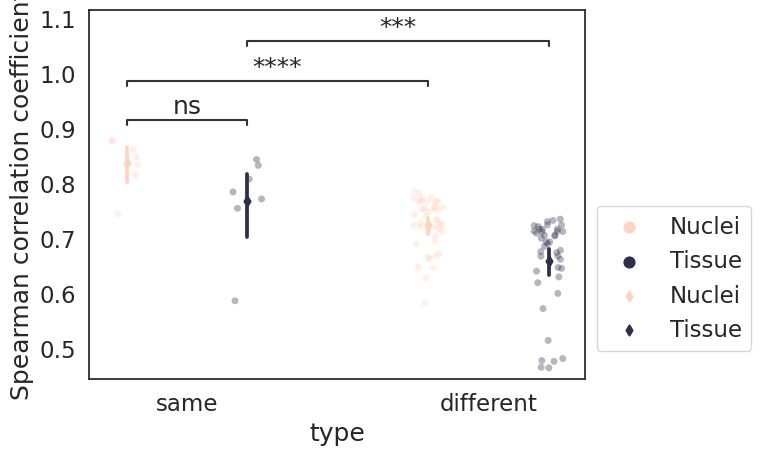

In [122]:

palette = ["#CDC392","#F1F1E6","#F5F8FF","#9EB7E5","#648DE5","#304C89"]#"#A9A179",
from statannotations.Annotator import Annotator
ax = sns.stripplot(data=corr_, x="type", y="value", hue="a_type", palette=palette_exp, 
                  dodge=True, alpha=.35, zorder=1, s=10)
# sns.violinplot(data=corr_, x="type", y="value", hue="a_type", ax=ax, color=None)#, palette={"Nuclei":"#304C89", "Tissue": "#CDC392"}
sns.pointplot(ax=ax,
    data=corr_, x="type", y="value", hue="a_type",
    join=False,  palette=palette_exp,dodge=.8 - .8 / 2,
    markers="d", scale=.75, errorbar=None
)
ax.set_ylabel("Spearman correlation coefficient")
pairs=[(("different", "Nuclei"), ("same", "Nuclei")),
       (("same", "Tissue"), ("same", "Nuclei")),
       (("different", "Tissue"), ("same", "Tissue"))]

annotator = Annotator(ax, pairs, data=corr_, x="type", y="value", hue="a_type")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()
ax.legend(bbox_to_anchor=(1,0.5))
plt.savefig(os.path.join(savepath, "distribution_correlation_coefficient_dec_snrna_same_different_ct_mice.svg"))

# snRNA Autocorrrelation matrix

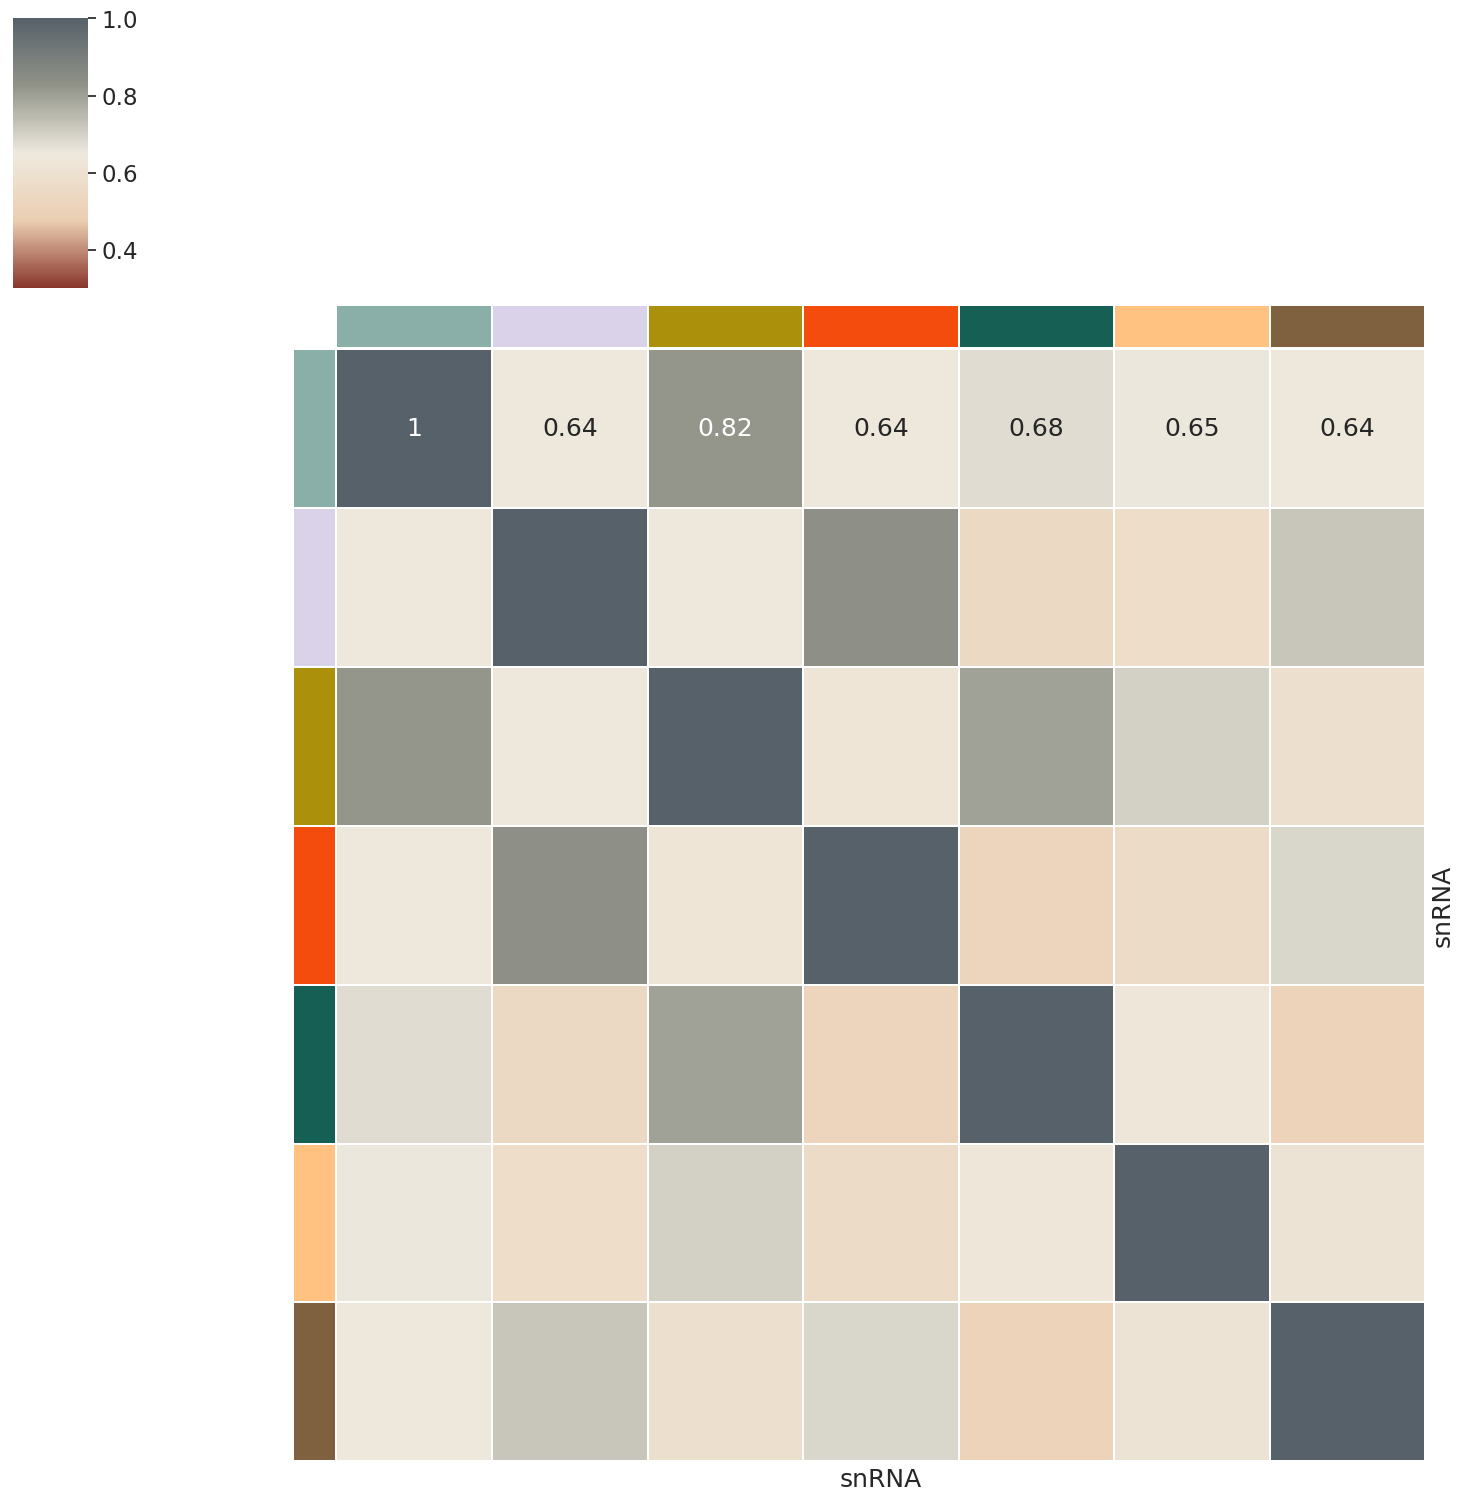

In [123]:
mat = mE.set_index(["celltype", "method"])[all_genes].astype(float).T.corr("pearson")#.reset_index()
mat

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat =mat.reset_index()
mat.method.unique()

x = "snRNA"
mat = mat[mat["method"] ==x].set_index(["celltype", "method"]).T.reset_index()
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat
y="Nuclei"

mat = mat[(mat["index_"].str.contains(x)) ].set_index(["index_"])
#mat = mat[(mat["index_"].str.contains(y)) ].set_index(["index_"])
mat

# print(mat)
# sns.set(font_scale=2)
#fig, ax = plt.subplot
col_colors_cell =mat.reset_index()["index_"].str.split("_", expand=True)[0].map(PALETTE)
#col_colors_exp =mat.reset_index()["index_"].str.split("_", expand=True)[1].map(palette_exp)

row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(PALETTE)
row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_exp)

ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap, 
                   row_colors=[col_colors_cell], col_colors=[row_col], vmin=0.3, vmax=1, linewidth=0.2,annot=True)
ax = g.ax_heatmap
ax.set_xlabel("snRNA")
ax.set_ylabel("snRNA")
# ax.set_xlabel(x)
# ax.set_ylabel(y)
plt.savefig(os.path.join(savepath, "heat_matrix_autocorr_snrna_snrna_mice.svg"))

In [124]:
sc_df = snRNA.to_df()
sc_df.columns = single_cell.var["gene_symbol"].tolist()
sc_df["Experiment"] ="snRNA"
sc_df["method"] ="snRNA"
sc_df["celltypes"] = single_cell.obs["celltype"].tolist()

sc_df["Group"] = single_cell.obs["Sample_num"].str.split("_",expand=True)[1].map({"AD":"D","CTRL":"ND"}).values
sc_df["Diagnosis"] = single_cell.obs["Sample_num"].str.split("_",expand=True)[1].map({"AD":"D","CTRL":"ND"}).values
sc_df["Sample_num"] =  single_cell.obs["Sample_num"].str.rsplit("_",n=1, expand=True)[0]
sc_df["Sex"] = single_cell.obs['Sex'].map({"Male":"M", "Female":"F"})
sc_df

,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,...,TTTY10,EIF1AY,LINC00266-4P,Experiment,method,celltypes,Group,Diagnosis,Sample_num,Sex
AAACCCACAGCTGTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,AST,D,D,3_AD,M
AAACGAAGTTGCATTG-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,OLD,D,D,3_AD,M
AAACGAATCTCTCTTC-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,snRNA,snRNA,OLD,D,D,3_AD,M
AAAGGATAGATCACTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,snRNA,snRNA,OLD,D,D,3_AD,M
AAAGGGCAGCTGACAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,OLD,D,D,3_AD,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGGCGCACATACTG-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,snRNA,snRNA,MIC,D,D,20_AD,M
TTGTGTTCACGGTAGA-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,AST,D,D,20_AD,M
TTTCATGGTCGACTTA-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,EXC,D,D,20_AD,M
TTTGACTAGTAAGGGA-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,snRNA,snRNA,OLD,D,D,20_AD,M


In [157]:
'/remote/home/eloiseb/experiments/deconv_rna/berson_map1_18k_totlognorm_nosparse_all_training/exp_kfold_0/test/bulk_sample_decon_bulk_nuclei_all_18k/bulk_sample_decon/labels_Test.npz'

'/remote/home/eloiseb/experiments/deconv_rna/berson_map1_18k_totlognorm_nosparse_all_training/'

In [158]:
# celltypes = ['AST', 'Endo-Mural', 'EXC-L23', 'EXC-L4', 'EXC-L5', 'EXC-L6','
#        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo-Mural', 'EXC',
#        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo', 'EXC-IT',  'EXC-L6-spe',
#        'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC', "VLMC"]
fold = 0
model_f = model + "exp_kfold_%s/test/"%str(fold)
deconv_ = model_f + "bulk_sample_decon_bulk_tissue_all_18k/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "bulk_sample_decon_bulk_tissue_all_18k/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll[ll<0] = 0
ll.shape
# ll = ll*mask[np.newaxis, :, :]

df_tissue = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_tissue.loc[len(df_tissue), :] = [it, ct] + ll[i,j, :].tolist()
# df_tissue = df_tissue[df_tissue.Sample_num.isin(both_exp)]
df_tissue.Sample_num =df_tissue["Sample_num"].astype(int).map(mapping_)
df_tissue["Diagnosis"] = df_tissue["Sample_num"].str.split("_", expand=True)[1].values
df_tissue


deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_all_18k/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_all_18k/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll.shape
ll[ll<0] = 0
# ll = ll*mask[np.newaxis, :, :]

df_nuclei = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_nuclei.loc[len(df_nuclei), :] = [it, ct] + ll[i,j, :].tolist()

df_nuclei.Sample_num =df_nuclei["Sample_num"].astype(int).map(mapping_)
df_nuclei.Sample_num

0        9_D
1        9_D
2        9_D
3        9_D
4        9_D
       ...  
107    18_ND
108    18_ND
109    18_ND
110    18_ND
111    18_ND
Name: Sample_num, Length: 112, dtype: object

In [159]:
bulk_t = df_tissue#.reset_index().rename({"index":"Sample_num"}, axis=1)
bulk_t["Group"] = bulk_t["Sample_num"].str.split("_",expand=True)[1]
# bulk_t["Mice"] = bulk_t["Sample_num"].str.split("_",expand=True)[1].str.replace('\d+', '')
bulk_t

bulk_t["Experiment"] = "Tissue"
bulk_t = bulk_t.merge(metadata[["Sample_num","Sex"]], on="Sample_num")
bulk_nuclei = df_nuclei#.reset_index().rename({"index":"Sample_num"}, axis=1)
bulk_nuclei["Group"] = bulk_nuclei["Sample_num"].str.split("_",expand=True)[1]
# bulk_nuclei["Mice"] = bulk_nuclei["Sample_num"].str.split("_",expand=True)[1].str.replace('\d+', '')
bulk_nuclei
bulk_nuclei["Experiment"] = "Nuclei"
bulk_nuclei = bulk_nuclei.merge(metadata[["Sample_num","Sex"]], on="Sample_num")



bulk_nuclei

,Sample_num,celltypes,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,HSFY1,HSFY2,TTTY14,KDM5D,TTTY10,EIF1AY,LINC00266-4P,Group,Experiment,Sex
0,9_D,AST,59.42926,592.207458,0.0,28.553085,1314.817017,342.77182,153.194168,0.0,...,0.021767,0.026751,0.432806,0.0,0.140021,0.009711,0.0,D,Nuclei,F
1,9_D,Endo-Mural,0.0,110.640701,0.0,0.0,298.191864,103.990807,18.175264,0.0,...,0.014731,0.0,0.347588,0.022181,0.0,0.016302,0.0,D,Nuclei,F
2,9_D,EXC,7.173658,0.0,2.866344,9.176657,15.693634,1.620632,0.0,4.196907,...,0.0,0.0,0.093829,0.0,0.012759,0.0,0.0,D,Nuclei,F
3,9_D,INH,16.043331,75.437744,0.0,5.728958,479.682922,83.097687,0.0,70.532837,...,0.0,0.026103,0.500337,0.002174,0.225056,0.0,0.0,D,Nuclei,F
4,9_D,MIC,65.790672,191.650909,26.267382,6.010637,836.446594,63.83923,0.0,0.0,...,0.0,0.0,0.431688,0.0,0.082747,0.0,0.0,D,Nuclei,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,18_ND,EXC,21.281637,33.98251,12.44495,14.82354,194.060928,58.410622,26.884834,14.958971,...,49.362793,23.487463,276.613098,70.697388,40.31879,0.0,0.0,ND,Nuclei,M
108,18_ND,INH,4.034477,2.701421,0.0,0.0,3.589573,1.379595,0.0,0.0,...,3.499183,0.0,148.147629,44.177845,18.840691,0.0,0.0,ND,Nuclei,M
109,18_ND,MIC,61.474899,126.180992,10.829104,0.0,737.855652,110.482422,11.065416,29.352646,...,0.0,0.0,508.807861,449.141541,119.382935,103.195061,0.0,ND,Nuclei,M
110,18_ND,OLD,0.0,67.949821,0.0,65.86467,514.08606,110.771645,13.711082,26.659363,...,0.0,0.0,392.612488,216.193542,47.831123,50.517147,0.0,ND,Nuclei,M


In [173]:
pseudo_ = pseudo_.rename({"celltype":"celltypes"}, axis=1)
pseudo_["Experiment"] = "snRNA"
pseudo_["Group"] = pseudo_["Sample_num"].str.split("_",expand=True)[1]

In [174]:
combine = pd.concat([bulk_t, bulk_nuclei, pseudo_], axis=0)
combine
combine["Sample_ind"] = combine["Sample_num"] + "_" + combine["Experiment"]

In [175]:
combine

,Sample_num,celltypes,FAM87B,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,...,TTTY14,KDM5D,TTTY10,EIF1AY,LINC00266-4P,Diagnosis,Group,Experiment,Sex,Sample_ind
0,10_ND,AST,0.0,647.879822,0.0,44.75288,1242.762817,167.172714,61.814171,14.461161,...,153.810471,959.771179,12.999923,110.315575,0.0,ND,ND,Tissue,M,10_ND_Tissue
1,10_ND,Endo-Mural,0.0,18.626068,7.581229,0.0,38.595131,7.465313,12.72852,0.0,...,39.355713,226.84317,5.388989,19.932711,0.0,ND,ND,Tissue,M,10_ND_Tissue
2,10_ND,EXC,2.998342,0.0,0.0,8.438168,0.0,0.0,0.151585,0.856054,...,4.818512,10.000096,0.0,3.624626,0.0,ND,ND,Tissue,M,10_ND_Tissue
3,10_ND,INH,24.753031,52.62986,0.0,0.0,435.902466,48.340374,0.0,114.749084,...,47.054733,234.615799,15.212193,3.972476,0.0,ND,ND,Tissue,M,10_ND_Tissue
4,10_ND,MIC,3.034147,27.230875,10.408989,0.0,81.636253,0.0,2.272599,0.0,...,38.223076,246.246811,0.0,24.748985,0.0,ND,ND,Tissue,M,10_ND_Tissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,20_D,EXC,0.0,0.40158,0.0,0.0,0.203524,0.08627,0.0,0.0,...,8.775212,1.288578,1.13062,0.0,0.0,NaN,D,snRNA,NaN,20_D_snRNA
108,20_D,INH,0.0,0.171429,0.025397,0.0,0.133333,0.022222,0.0,0.0,...,6.022222,0.774603,0.869841,0.0,0.0,NaN,D,snRNA,NaN,20_D_snRNA
109,20_D,MIC,0.0,0.031175,0.0,0.0,0.021583,0.0,0.0,0.0,...,0.41247,0.105516,0.052758,0.0,0.0,NaN,D,snRNA,NaN,20_D_snRNA
110,20_D,OLD,0.0,0.022042,0.0058,0.0,0.038283,0.0,0.0,0.0,...,0.350348,0.182715,0.103248,0.034223,0.0,NaN,D,snRNA,NaN,20_D_snRNA


In [183]:

# from statsmodels.stats.multitest import multipletests 
#from pydeseq2.default_inference import DefaultInference
# #import diffxpy.api as de
# from statannotations.Annotator import Annotator
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, RepeatedKFold, RepeatedStratifiedKFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu, spearmanr, pearsonr

# from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from joblib import Parallel, delayed
from sklearn.feature_selection import VarianceThreshold 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
atac_input_file_name = "/home/eloiseb/data/ATAC-seq_2024/adata_deconvolution_PD_2024_trained_all_filtered_feb24_lognorm.h5ad"
# atac_input_file_name = "/home/eloiseb/tmp/adata_ct.h5ad"

outdir = "./outdir_plot_res/"
outdir = "./outdir_plot_res"



feat_ = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
import os
models = {
                                'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                                'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                                'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                                'Random Forest': RandomForestClassifier(n_jobs=-1),
                                'KNN': KNeighborsClassifier(n_jobs=-1),
                                'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                                'XGBoost': XGBClassifier(n_jobs=-1),
                                # "LGBM":LGBMClassifier(random_state=1)
                            }

variance_thres = 0.0

                   
def train_final(X,y,group,ri, mod,
                n_out_splits,exp,
               ct):
    l_y_pred = []
    l_y_pred_c = []
    l_y_test = []
    pred_dum = []
    pred_dum_c = []
    res = pd.DataFrame( columns=['model','celltype',"Experiment",'AUROC',"AUPRC","pvalue", "F1", "AUROC random", "AUPRC random", "F1 random"])
    i = 0
    rng = np.random.default_rng(ri)
    rints = rng.integers(low=0, high=1000, size=1)
    outer_cv =  StratifiedKFold(n_splits=n_out_splits, shuffle=True,  random_state=rints[0])
    nb_ = len(y)
    df_results = pd.DataFrame(columns=["case","iter"]+np.arange(nb_).tolist())
    for i1, (train_index, test_index) in enumerate(outer_cv.split(X,y,groups=group)):
        
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
                            # patient_inner = pat[train_index]
        if (len(set(y_train))>1) & (len(set(y_test))>1):
            pipe = Pipeline([#("scale", StandardScaler()),
                             #("filter",VarianceThreshold(threshold=variance_thres)),
                                                   # ("red", PCA(n_components=len(train_index))),
                                                       # ("select", SelectKBest(f_classif,k=nb)),
                                                    ("model", models[mod])
                                                    ])
            pipe.fit(np.array(X_train), np.array(y_train))
    
            y_pred = np.array(pipe.predict_proba(np.array(X_test))[:, 1])
            y_pred_c = np.array(pipe.predict(np.array(X_test)))
            tmp = np.empty((nb_))
            tmp[test_index] = y_pred
            df_results.loc[len(df_results),:] = ["pred",i1] + tmp.tolist()
            tmp = np.empty((nb_))
            tmp[test_index] = y_test
            df_results.loc[len(df_results),:] = ["true",i1] + tmp.tolist()
            l_y_pred.append(y_pred)
            l_y_test.append(y_test)
            l_y_pred_c.append(y_pred_c)
            pipe = Pipeline([#("scale", StandardScaler()),
                             ("filter",VarianceThreshold(threshold=variance_thres)),

                                                    # ("red", PCA(n_components=len(train_index))),
                                                       # ("select", SelectKBest(f_classif,k=nb)),
                                                    ("model", DummyClassifier())
                                                    ])
            pipe.fit(np.array(X_train), np.array(y_train))
            y_pred_dummy = np.array(pipe.predict_proba(np.array(X_test))[:, 1])
            pred_dum.append(y_pred_dummy)  
            y_pred_dummy = np.array(pipe.predict(np.array(X_test)))
            pred_dum_c.append(y_pred_dummy)   
    y_preds = np.hstack(l_y_pred)
    y_preds_c = np.hstack(l_y_pred_c)
    y_tests = np.hstack(l_y_test)
    y_pred_du = np.hstack(pred_dum)
    y_pred_du_c = np.hstack(pred_dum_c)
    auc = roc_auc_score(y_tests, y_preds)#, average="weighted")
    auprc = average_precision_score(y_tests, y_preds)#, average="weighted")#np.mean(l_auroc)
    f1 = f1_score(y_tests, y_preds_c)#, average="weighted")
    pv = mannwhitneyu(y_preds[y_tests==0], y_preds[y_tests==1]).pvalue
    auc_dum = roc_auc_score(y_tests, y_pred_du)#, average="weighted")
    auprc_dum = average_precision_score(y_tests, y_pred_du)#, average="weighted")
    f1_dum = average_precision_score(y_tests, y_pred_du_c)#, average="weighted")

    res.loc[0,:] = [mod, ct,exp,auc, auprc,pv,f1,auc_dum, auprc_dum, f1_dum]
    
    return res, df_results



warnings.filterwarnings("ignore")
model_list = ['LASSO', 'Ridge', 'EN','Random Forest', 'SVM', "XGBoost"]#,"LGBM" ]
# celltypes  = list(adata.obs.celltype.unique())

i = 0
#for nb in [2, 5, 10, 15, 20,25,40, 50,60, 75, 100]:
with_sex= False
with_age = False

n_out_splits = 5
nb_boostrap = 5
nb_boostrap1 = 5
min_count = 5
min_total_count =15

n_out_splits = 5

# outer_cv = StratifiedKFold(n_splits=10,shuffle=True)
outer_cv_results = {key: [] for key in [ "ct", "outer_split","ri", "n_features", "algo", "F1","AUROC", "AUPRC","F1 random","AUROC random", "AUPRC random"]}

res = []
res_inn = []
if True:
    cond0,cond1 = "D","ND"
    namef = "./multivariate_d_nd_hu_filtered.pickle"
    # if not os.path.exists(namef):
    for exp in combine["Experiment"].unique():
            print(namef)
        # for br in brain_regions:
            for ct in celltypes:
               for l_mod in model_list:
                    
                    print(ct)
                    
                   
                    condition_filtering = (#(com.condition.isin([cond0,cond1]))
                                           combine.celltypes.isin([ct])
                                           & (combine.Experiment.isin([exp])))
                    dict_cond = {cond0:1,cond1:0}


                    conds = combine["Group"].unique().tolist()
                    dict_cond = {it:1 if it ==cond0 else 0 for it in conds}
                    comb_filtered = combine[condition_filtering]
                    
                    # comb_filtered =  comb_filtered[comb_filtered.X.sum(0)!=0]

                    patients,X,y = (comb_filtered[["Sample_num","Group"]].reset_index(drop=True),
                                    comb_filtered[genes].values, comb_filtered["Group"].map(dict_cond).values)



                    ma = X.copy()
                    ma[ma<=min_count] = 0
                    ma[ma>min_count] = 1
                    list_ = ma.sum(0)>min_count
                    list_2 = X.astype(float).sum(0)>min_total_count
                    # list_e = [it for ii, it in enumerate(list_) if it and list_2[ii]]
                    list_e = [True if it and list_2[ii] else False for ii, it in enumerate(list_) ]
                    X = X[:,list_e]
                    print(X.shape)
                   
                    pat = comb_filtered["Sample_num"].tolist()
                 
                    outal = Parallel(n_jobs=30, verbose=100)(
                                                delayed(train_final)(X,y,pat,ri,l_mod,
                                                                     n_out_splits,exp,
                                           ct) for ri in tqdm(range(nb_boostrap)))
                    # print(out)
                    out = [it[0] for it in outal]
                    pred_df = [it[1] for it in outal]
                    pred_df = pd.concat(pred_df)
                    # pred_df_ctrl = pd.concat([it[2] for it in outal])
                    # pred_df_lrrk2 = pd.concat([it[2] for it in outal])
                    # print(out)
                  
                    pred_df["ct"] = ct
                    pred_df["Experiment"] = exp
                    rest = pd.concat(out)
                    mean_auc = np.mean(rest["AUROC"].values)
                    std_auc = np.std(rest["AUROC"].values)
                    mean_au = np.mean(rest["AUPRC"].values)
                    mean_f1 = np.mean(rest["F1"].values)
                    mea_du = np.mean(rest["AUROC random"].values)
                    # if mean_auc> mea_du:
                    #     pred_df.to_pickle("%s_%s_%s_with_sex_age.pickle"%(br,ct,comp))
                    #     # pred_df_ctrl["br"] = br
                        # pred_df_ctrl["ct"] = ct
                        # pred_df_lrrk2["br"] = br
                        # pred_df_lrrk2["ct"] = ct
                        # pred_df_ctrl.to_pickle("pred_ctrl_%s_%s_%s_with_sex_age.pickle"%(br,ct,comp))
                        # red_df_lrrk2.to_pickle("pred_lrrk2_%s_%s_%s_with_sex_age.pickle"%(br,ct,comp))
                    print(f"{ct}, {l_mod}: AUC: {mean_auc} +/- {std_auc}, AUPRC: {mean_au}, f1: {mean_f1}, random: {mea_du}") 
                    res.append(rest)
                    i+=1
    pd.concat(res).to_pickle(namef)         
pd.concat(res).to_pickle(namef)


./multivariate_d_nd_hu_filtered.pickle
AST
(16, 16485)


100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3759.68it/s]

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.



Exception ignored in: Traceback (most recent call last):
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/joblib/__init__.py", line 114, in <module>
    from .memory import Memory
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/joblib/memory.py", line 18, in <module>
    import pydoc
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/pydoc.py", line 65, in <module>
    import pkgutil
  File "/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/pkgutil.py", line 22, in <module>
<function _releaseLock at 0x7f36c2463f40>
Traceback (most recent call last):
  File "/home/eloiseb/miniconda3/envs/pytorch_env

ValueError: semaphore or lock released too many times

In [59]:
# res.to_pickle("multivariate_hu_celltypemap3.pickle")

In [179]:
# combine = combine.merge(metadata[["Sample_num","Sex"]], on="Sample_num")
# combine.rename(columns={"Sex_x":"Sex"}, inplace=True)
res = pd.concat(res)
res
# final = pd.concat(res)

,model,celltype,Experiment,AUROC,AUPRC,pvalue,F1,AUROC random,AUPRC random,F1 random
0,LASSO,AST,Tissue,0.714286,0.722338,0.173776,0.842105,0.365079,0.507275,0.5625
0,LASSO,AST,Tissue,0.761905,0.809027,0.090734,0.777778,0.365079,0.507275,0.5625
0,LASSO,AST,Tissue,0.650794,0.646473,0.351049,0.705882,0.365079,0.507275,0.5625
0,LASSO,AST,Tissue,0.761905,0.787963,0.090734,0.736842,0.365079,0.507275,0.5625
0,LASSO,AST,Tissue,0.698413,0.775408,0.21049,0.631579,0.365079,0.507275,0.5625
...,...,...,...,...,...,...,...,...,...,...
0,XGBoost,OPC,snRNA,0.674603,0.697619,0.266028,0.7,0.365079,0.507275,0.5625
0,XGBoost,OPC,snRNA,0.698413,0.718232,0.203342,0.761905,0.365079,0.507275,0.5625
0,XGBoost,OPC,snRNA,0.555556,0.613492,0.749933,0.666667,0.365079,0.507275,0.5625
0,XGBoost,OPC,snRNA,0.674603,0.690135,0.264262,0.736842,0.365079,0.507275,0.5625


In [133]:
# namef = "./multivariate_d_nd_hu.pickle"
# res= pd.read_pickle(namef)
res

,model,celltype,Experiment,AUROC,AUPRC,pvalue,F1,AUROC random,AUPRC random,F1 random
0,LASSO,AST,PD_PDD,0.621693,0.579329,0.199907,0.564103,0.448413,0.436859,0.461538
0,LASSO,AST,PD_PDD,0.653439,0.611333,0.105258,0.540541,0.448413,0.436859,0.461538
0,LASSO,AST,PD_PDD,0.640212,0.613938,0.139135,0.555556,0.448413,0.436859,0.461538
0,LASSO,AST,PD_PDD,0.592593,0.571836,0.331087,0.564103,0.448413,0.436859,0.461538
0,LASSO,AST,PD_PDD,0.589947,0.538035,0.345295,0.457143,0.448413,0.436859,0.461538
...,...,...,...,...,...,...,...,...,...,...
0,XGBoost,OPC,CONTR_PDD,0.374396,0.392459,0.17608,0.30303,0.439614,0.409011,0.439024
0,XGBoost,OPC,CONTR_PDD,0.236715,0.323207,0.004367,0.285714,0.439614,0.409011,0.439024
0,XGBoost,OPC,CONTR_PDD,0.400966,0.433151,0.287352,0.2,0.439614,0.409011,0.439024
0,XGBoost,OPC,CONTR_PDD,0.391304,0.407435,0.242391,0.235294,0.439614,0.409011,0.439024


In [148]:
final = res[res.model=="Ridge"]

In [180]:
final = []
for ct in res.celltype.unique():
    for exp in res.Experiment.unique():
        tmp = res[(res.celltype==ct) &(res.Experiment==exp)]
        tmp2 =tmp.groupby(["model"]).agg({"AUROC":"mean", "AUPRC":"mean"})
        tmp2 = tmp2.sort_values("AUROC", ascending=False)
        best_m = tmp2.index[0]
        tmp3 = tmp[tmp.model ==best_m]
        final.append(tmp3)
final = pd.concat(final)

In [181]:
final["Experiment"] = final["Experiment"].replace({"Nuclei":"Deconvoluted Nuclei", "Tissue":"Deconvoluted Tissue"})

In [186]:
final

,model,celltype,Experiment,AUROC,AUPRC,pvalue,F1,AUROC random,AUPRC random,F1 random
0,Random Forest,AST,Deconvoluted Tissue,0.841270,0.88945,0.022902,0.736842,0.365079,0.507275,0.5625
0,Random Forest,AST,Deconvoluted Tissue,0.873016,0.929321,0.011538,0.842105,0.365079,0.507275,0.5625
0,Random Forest,AST,Deconvoluted Tissue,0.817460,0.876972,0.038865,0.777778,0.365079,0.507275,0.5625
0,Random Forest,AST,Deconvoluted Tissue,0.865079,0.925253,0.017153,0.823529,0.365079,0.507275,0.5625
0,Random Forest,AST,Deconvoluted Tissue,0.761905,0.843723,0.089153,0.705882,0.365079,0.507275,0.5625
...,...,...,...,...,...,...,...,...,...,...
0,Ridge,OPC,snRNA,0.730159,0.804436,0.141608,0.736842,0.365079,0.507275,0.5625
0,Ridge,OPC,snRNA,0.825397,0.862285,0.031119,0.777778,0.365079,0.507275,0.5625
0,Ridge,OPC,snRNA,0.730159,0.783393,0.141608,0.588235,0.365079,0.507275,0.5625
0,Ridge,OPC,snRNA,0.682540,0.758538,0.252273,0.625,0.365079,0.507275,0.5625


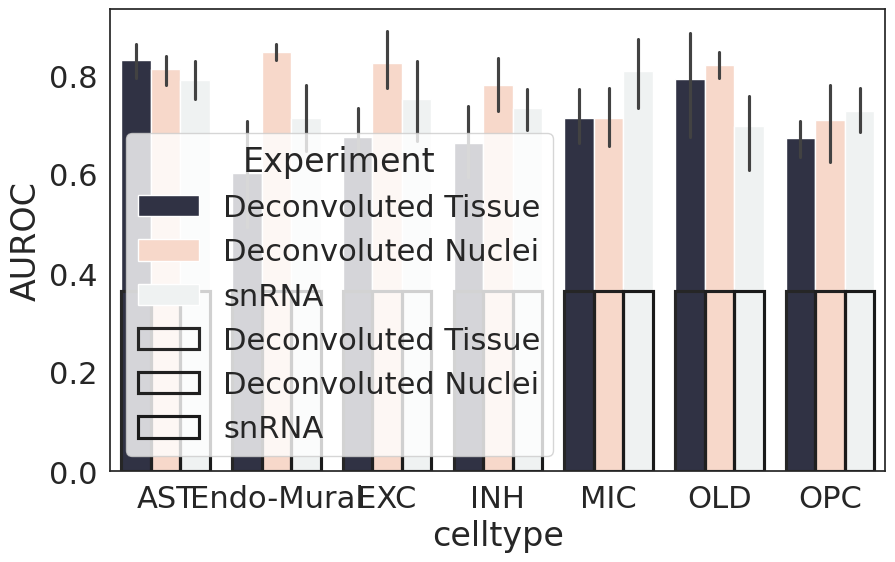

In [188]:
from statannotations.Annotator import Annotator

palette_exp["Deconvoluted Nuclei"] = palette_exp["Nuclei"]
palette_exp["Deconvoluted Tissue"] = palette_exp["Tissue"]
# final = final[final.Experiment !="Deconvoluted Tissue"]

import seaborn as sns
cond = "SPOR$GBA1"
Exp = "Tissue"
tmp = final#[final.Experiment ==Exp]
# sns.set(style="white", font_scale=1.2)
# g = sns.FacetGrid(data=tmp, col="Experiment", col_wrap=1,height=4, aspect=3,)
# g.map_dataframe(sns.barplot, x="celltype", y="AUROC", hue="model", palette="tab20")#, palette=PALETTE)#, style="model")
# # g.map_dataframe(sns.barplot, x="celltype", y="AUROC random", hue="model", fill=False,color="black")#, style="model")


# for ax in g.axes.flatten():
#     ax.axhline(y=0.5, c="k")
#     ax.axhline(y=0.7, c="k", linestyle=":")
# #     #ax.axhline(y=0.8, c="k", linestyle="--")
# #     tit = ax.get_title()
# #     tit = tit.replace("covar =", "").replace("$", "vs")
# #     ax.set_title(tit)
# #     for i, bar in enumerate(ax.patches):
# #         if i >=66:
# #             bar.set_hatch("//")
# #             bar.set_edgecolor("k")
# #     #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.legend()
# plt.show()
final["AUROC"] = final["AUROC"].astype(float)
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=final, x="celltype", y="AUROC", hue="Experiment", ax=ax, palette=palette_exp)
sns.barplot(data=final, x="celltype", y="AUROC random", hue="Experiment", ax=ax, color="k", fill=False)

pairs=[((ct, "Deconvoluted Nuclei"), (ct, "Deconvoluted Tissue")) for ct in celltypes]
pairs+=[((ct, "Deconvoluted Nuclei"), (ct, "snRNA")) for ct in celltypes]
pairs+=[((ct, "Deconvoluted Tissue"), (ct, "snRNA")) for ct in celltypes]
      

# annotator = Annotator(ax, pairs, data=final, x="celltype", y="AUROC", hue="Experiment")
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
# annotator.apply_and_annotate()

# Exp = "Nuclei"
# tmp = final[final.Experiment ==Exp]
# sns.set(style="white", font_scale=1.2)
# g = sns.FacetGrid(data=tmp, col="covar", col_wrap=4,height=4, aspect=1,)
# g.map_dataframe(sns.barplot, x="celltype", y="AUROC", hue="method", palette=COLORS_CT)#, style="model")
# g.map_dataframe(sns.barplot, x="celltype", y="auc_dum", hue="method", fill=False,color="black")#, style="model")


# for ax in g.axes.flatten():
#     ax.axhline(y=0.5, c="k")
#     #ax.axhline(y=0.7, c="k", linestyle=":")
#     #ax.axhline(y=0.8, c="k", linestyle="--")
#     tit = ax.get_title()
#     tit = tit.replace("covar =", "").replace("$", "vs")
#     ax.set_title(tit)
#     for i, bar in enumerate(ax.patches):
#         if i >=29:
#             bar.set_hatch("//")
#             bar.set_edgecolor("k")
#     #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.show()
plt.savefig(os.path.join(savepath, "model_cv_ad_ctrl_hu.svg"))

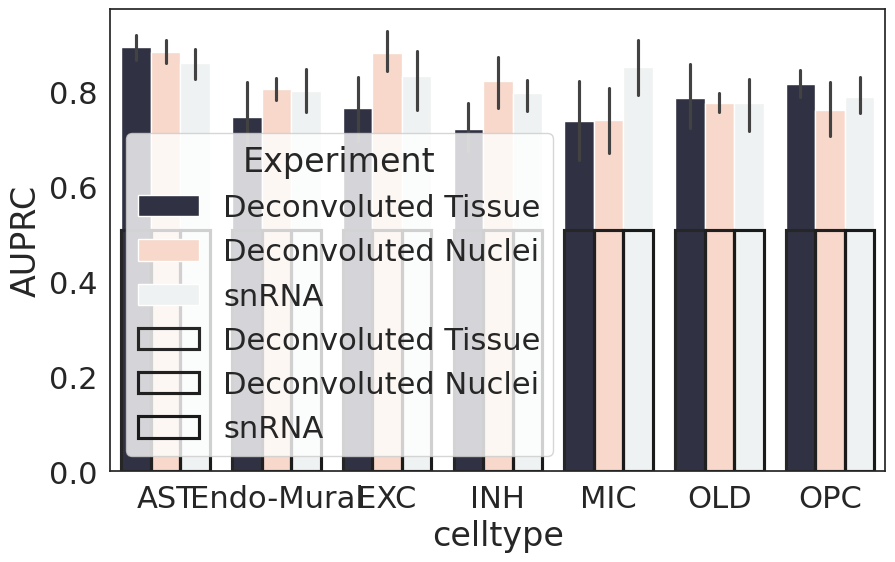

In [189]:
from statannotations.Annotator import Annotator

palette_exp["Deconvoluted Nuclei"] = palette_exp["Nuclei"]
palette_exp["Deconvoluted Tissue"] = palette_exp["Tissue"]
# final = final[final.Experiment !="Deconvoluted Tissue"]

import seaborn as sns
cond = "SPOR$GBA1"
Exp = "Tissue"
tmp = final#[final.Experiment ==Exp]
# sns.set(style="white", font_scale=1.2)
# g = sns.FacetGrid(data=tmp, col="Experiment", col_wrap=1,height=4, aspect=3,)
# g.map_dataframe(sns.barplot, x="celltype", y="AUROC", hue="model", palette="tab20")#, palette=PALETTE)#, style="model")
# # g.map_dataframe(sns.barplot, x="celltype", y="AUROC random", hue="model", fill=False,color="black")#, style="model")


# for ax in g.axes.flatten():
#     ax.axhline(y=0.5, c="k")
#     ax.axhline(y=0.7, c="k", linestyle=":")
# #     #ax.axhline(y=0.8, c="k", linestyle="--")
# #     tit = ax.get_title()
# #     tit = tit.replace("covar =", "").replace("$", "vs")
# #     ax.set_title(tit)
# #     for i, bar in enumerate(ax.patches):
# #         if i >=66:
# #             bar.set_hatch("//")
# #             bar.set_edgecolor("k")
# #     #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.legend()
# plt.show()
final["AUROC"] = final["AUROC"].astype(float)
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=final, x="celltype", y="AUPRC", hue="Experiment", ax=ax, palette=palette_exp)
sns.barplot(data=final, x="celltype", y="AUPRC random", hue="Experiment", ax=ax, color="k", fill=False)

pairs=[((ct, "Deconvoluted Nuclei"), (ct, "Deconvoluted Tissue")) for ct in celltypes]
pairs+=[((ct, "Deconvoluted Nuclei"), (ct, "snRNA")) for ct in celltypes]
pairs+=[((ct, "Deconvoluted Tissue"), (ct, "snRNA")) for ct in celltypes]
      

# annotator = Annotator(ax, pairs, data=final, x="celltype", y="AUROC", hue="Experiment")
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
# annotator.apply_and_annotate()

# Exp = "Nuclei"
# tmp = final[final.Experiment ==Exp]
# sns.set(style="white", font_scale=1.2)
# g = sns.FacetGrid(data=tmp, col="covar", col_wrap=4,height=4, aspect=1,)
# g.map_dataframe(sns.barplot, x="celltype", y="AUROC", hue="method", palette=COLORS_CT)#, style="model")
# g.map_dataframe(sns.barplot, x="celltype", y="auc_dum", hue="method", fill=False,color="black")#, style="model")


# for ax in g.axes.flatten():
#     ax.axhline(y=0.5, c="k")
#     #ax.axhline(y=0.7, c="k", linestyle=":")
#     #ax.axhline(y=0.8, c="k", linestyle="--")
#     tit = ax.get_title()
#     tit = tit.replace("covar =", "").replace("$", "vs")
#     ax.set_title(tit)
#     for i, bar in enumerate(ax.patches):
#         if i >=29:
#             bar.set_hatch("//")
#             bar.set_edgecolor("k")
#     #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.show()
plt.savefig(os.path.join(savepath, "model_cv_ad_ctrl_hu_auprc.svg"))